In [1]:
!pip install tensorflow -q
# !python -v

In [2]:
!pip install SpeechRecognition pydub -q

In [3]:
!pip install toloka-kit -q

!python3.10

In [4]:
!pip install xlrd -q

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pydub import AudioSegment
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
import IPython.display as ipd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
import toloka.client
toloka_client = toloka.client.TolokaClient(
  'T13G0USVrAJlXKx4VmjHlA.045e.157M3UiypS9H4MuCrRyOGLpAoHB0LQ9AAE6vZFcLeN8he6cYVsKU2Ne9XJuHJbzi7IJOlHEJxCynEXIC8sHWG_xiL626rBDkVLlJEXzWzsA', 'PRODUCTION')

In [6]:
text_A = pd.read_csv("TextA.tsv", sep='\t')
text_A_add = pd.read_csv("TextA++.tsv", sep='\t')
text_B = pd.read_csv("TextB.tsv", sep='\t')
text_B_add = pd.read_csv("TextB++.tsv", sep='\t')
text_C = pd.read_csv("TextC.tsv", sep='\t')
text_C_add = pd.read_csv("TextC++.tsv", sep='\t')
text_D = pd.read_csv("TextD.tsv", sep='\t')
text_D_add = pd.read_csv("TextD++.tsv", sep='\t')
users = pd.read_excel("users_data.xls")
countries = pd.read_excel("countries.xls")
english_speaking = pd.read_csv("english-speaking-countries-2024.csv")
english_speaking

country englishSpeakingCountries_isPrimary  \
0              India                                 No   
1      United States                                Yes   
2           Pakistan                                 No   
3            Nigeria                                Yes   
4         Bangladesh                                 No   
..               ...                                ...   
82          Anguilla                                 No   
83             Nauru                                 No   
84            Tuvalu                                 No   
85  Falkland Islands                                Yes   
86              Niue                                 No   

   englishSpeakingCountries_deJure englishSpeakingCountries_deFacto  \
0                              Yes                               No   
1                               No                              Yes   
2                              Yes                               No   
3                              Yes                              Yes   
4                               No                              Yes   
..                             ...                              ...   
82                             Yes                              Yes   
83                             Yes                              Yes   
84                             Yes                               No   
85                             Yes                              Yes   
86                             Yes                               No   

                       englishSpeakingCountries_notes  
0   Two official: Hindi, English. Neither is legal...  
1                                                 NaN  
2                     Two official: Urdu and English.  
3                                                 NaN  
4                                                 NaN  
..                                                ...  
82     English-based creole dialect is widely spoken.  
83                 Two official: Nauruan and English.  
84                                                NaN  
85                      English is official language.  
86                  Two official: Niuean and English.  

[87 rows x 5 columns]

In [7]:
english_speaking.replace({
                'Yes': True,
                'No': False
            }, inplace = True)
english_speaking['is_english_spoken'] = (english_speaking['englishSpeakingCountries_isPrimary']) | (english_speaking['englishSpeakingCountries_deJure']) | (english_speaking['englishSpeakingCountries_deFacto'])
english_speaking

country  englishSpeakingCountries_isPrimary  \
0              India                               False   
1      United States                                True   
2           Pakistan                               False   
3            Nigeria                                True   
4         Bangladesh                               False   
..               ...                                 ...   
82          Anguilla                               False   
83             Nauru                               False   
84            Tuvalu                               False   
85  Falkland Islands                                True   
86              Niue                               False   

    englishSpeakingCountries_deJure englishSpeakingCountries_deFacto  \
0                              True                            False   
1                             False                             True   
2                              True                            False   
3                              True                             True   
4                             False                             True   
..                              ...                              ...   
82                             True                             True   
83                             True                             True   
84                             True                            False   
85                             True                             True   
86                             True                            False   

                       englishSpeakingCountries_notes  is_english_spoken  
0   Two official: Hindi, English. Neither is legal...               True  
1                                                 NaN               True  
2                     Two official: Urdu and English.               True  
3                                                 NaN               True  
4                                                 NaN               True  
..                                                ...                ...  
82     English-based creole dialect is widely spoken.               True  
83                 Two official: Nauruan and English.               True  
84                                                NaN               True  
85                      English is official language.               True  
86                  Two official: Niuean and English.               True  

[87 rows x 6 columns]

In [8]:
countries_joined = pd.merge(countries, english_speaking[['country', 'is_english_spoken']], on='country', how='left')
countries_joined['is_english_spoken'].fillna(False, inplace=True)
countries_joined

Country code  Region ID           country  is_english_spoken
0             US         84     United States               True
1             AR         93         Argentina              False
2             BR         94            Brazil              False
3             CA         95            Canada               True
4             DE         96           Germany              False
..           ...        ...               ...                ...
216           FK     101519  Falkland Islands               True
217           MQ     101521        Martinique              False
218           SS     108137       South Sudan               True
219           SX     109724      Sint Maarten               True
220           AI         10          Anguilla               True

[221 rows x 4 columns]

In [9]:
# Concatenating all the texts
texts = pd.concat([text_A, text_A_add, text_B, text_B_add, text_C, text_C_add, text_D, text_D_add])
texts = texts.drop(['GOLDEN:result_3d_question', 'GOLDEN:result_1st_question', 
             'GOLDEN:result_2nd_question', 'GOLDEN:result_4th_question', 
             'HINT:text', 'HINT:default_language', 
             'ASSIGNMENT:status',
             'ASSIGNMENT:started', 'ACCEPT:verdict', 'ACCEPT:comment',
             'ASSIGNMENT:link', 'ASSIGNMENT:task_id'], axis = 1)
texts.head()

INPUT:audio  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   
2  https://storage.yandexcloud.net/toloka-chebota...   
3  https://storage.yandexcloud.net/toloka-chebota...   
4  https://storage.yandexcloud.net/toloka-chebota...   

                                         INPUT:image  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   
2  https://storage.yandexcloud.net/toloka-chebota...   
3  https://storage.yandexcloud.net/toloka-chebota...   
4  https://storage.yandexcloud.net/toloka-chebota...   

                          OUTPUT:recording OUTPUT:result_3d_question  \
0  eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249                        No   
1  eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a                       Yes   
2  eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b                        No   
3  eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba                        No   
4  eu.440419a1-a930-4eb2-b965-fb45c69df94e                        No   

  OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
0                         No                         No   
1                        Yes                         No   
2                         No                         No   
3                         No                        Yes   
4                         No                         No   

  OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
0                         No  00028edf7c--6613eacdecfe467e31a1b8cb   
1                         No  00028edf7c--6613ead849336b29782c831c   
2                         No  00028edf7c--6613eaf349336b29782c8615   
3                        Yes  00028edf7c--6613eb144e5be33a301bfdde   
4                         No  00028edf7c--6613eb6d4e5be33a301c075d   

               ASSIGNMENT:worker_id  
0  b2c2c06f6bf8eed800e25881029fbcf7  
1  6a77f4ba1d04551c0c776dbd7b38e2f5  
2  6e9fdeeb3d0dfb1afd888aa5c8d347e6  
3  f91d95a62d1c07da5f4ddae20e7e6b14  
4  6de9d807930d55fdddfaf3eecd0c8c13

In [10]:
texts

INPUT:audio  \
0    https://storage.yandexcloud.net/toloka-chebota...   
1    https://storage.yandexcloud.net/toloka-chebota...   
2    https://storage.yandexcloud.net/toloka-chebota...   
3    https://storage.yandexcloud.net/toloka-chebota...   
4    https://storage.yandexcloud.net/toloka-chebota...   
..                                                 ...   
375  https://storage.yandexcloud.net/toloka-chebota...   
376  https://storage.yandexcloud.net/toloka-chebota...   
377  https://storage.yandexcloud.net/toloka-chebota...   
378  https://storage.yandexcloud.net/toloka-chebota...   
379  https://storage.yandexcloud.net/toloka-chebota...   

                                           INPUT:image  \
0    https://storage.yandexcloud.net/toloka-chebota...   
1    https://storage.yandexcloud.net/toloka-chebota...   
2    https://storage.yandexcloud.net/toloka-chebota...   
3    https://storage.yandexcloud.net/toloka-chebota...   
4    https://storage.yandexcloud.net/toloka-chebota...   
..                                                 ...   
375  https://storage.yandexcloud.net/toloka-chebota...   
376  https://storage.yandexcloud.net/toloka-chebota...   
377  https://storage.yandexcloud.net/toloka-chebota...   
378  https://storage.yandexcloud.net/toloka-chebota...   
379  https://storage.yandexcloud.net/toloka-chebota...   

                            OUTPUT:recording OUTPUT:result_3d_question  \
0    eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249                        No   
1    eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a                       Yes   
2    eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b                        No   
3    eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba                        No   
4    eu.440419a1-a930-4eb2-b965-fb45c69df94e                        No   
..                                       ...                       ...   
375  eu.3569cba1-8e98-475a-84fe-971b0dc4c7e9                        No   
376  eu.2b5ec51b-70d7-4031-b831-afe54060cc27                        No   
377  eu.a9b263c4-ca44-4fcd-8bb5-dda675a82550         None of the above   
378  eu.1b1c26dc-3c87-4e71-ab4f-e3019d6ed609                       Yes   
379  eu.1a8f1692-71d0-407a-a2bf-b9507f4d5297                       Yes   

    OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
0                           No                         No   
1                          Yes                         No   
2                           No                         No   
3                           No                        Yes   
4                           No                         No   
..                         ...                        ...   
375                        Yes                        Yes   
376                         No                        Yes   
377                        Yes                        Yes   
378                        Yes                        Yes   
379                         No                        Yes   

    OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
0                           No  00028edf7c--6613eacdecfe467e31a1b8cb   
1                           No  00028edf7c--6613ead849336b29782c831c   
2                           No  00028edf7c--6613eaf349336b29782c8615   
3                          Yes  00028edf7c--6613eb144e5be33a301bfdde   
4                           No  00028edf7c--6613eb6d4e5be33a301c075d   
..                         ...                                   ...   
375                        Yes  00028ffbe7--664f3cb542ac8f441d6f43be   
376                        Yes  00028ffbe7--664f4f6cdb902752cf421fd8   
377          None of the above  00028ffbe7--664f6669db902752cf442474   
378                         No  00028ffbe7--664f70bd42ac8f441d74413b   
379                        Yes  00028ffbe7--664f81a5db902752cf460a93   

                 ASSIGNMENT:worker_id  
0    b2c2c06f6bf8eed800e25881029fbcf7  
1    6a77f4ba1d04551c0c776dbd7b38e2f5  
2    6e9fdeeb3d0dfb1afd888aa5c8d347e6  
3 

In [11]:
texts = texts.drop(texts[texts['ASSIGNMENT:assignment_id'] == '00028f1722--661d0181aeb55a00a818bff7'].index)
texts = texts.drop(texts[texts['ASSIGNMENT:assignment_id'] == '00028f783b--662d1639cb201c62ab79667b'].index)
texts = texts.drop(texts[texts['ASSIGNMENT:assignment_id'] == '00028f1722--661d027c3306b974e9392d36'].index)
texts = texts.drop(texts[texts['ASSIGNMENT:assignment_id'] == '00028f783b--662d169b567f51718c9d810b'].index)
texts = texts.reset_index(drop=True)

In [12]:
text_dict = {
1 : "When she was a child Jennifer liked sports and she played hockey and basketball for an all-boys team. She also worked as a model. At the age of 14 she knew she wanted to be an actress, so she went to New York City to look for work. She appeared in advertisements for MTV and the fashion company Zara and got work as an actress on TV. Her family moved to Los Angeles so that Jennifer could work on TV and in films.",
2 : "Monday is viewed by many to be the worst day of the week, as it marks the return to work following the weekend, when most full-time employees are given two days off. Most students attend school in the morning and return home in the afternoon (usually from about eight until three or seven until two), and most workers go to work in the morning and return home in the evening (usually from nine to five or eight to four).",
3 : "London is a famous and historic city. It is the capital of England in the United Kingdom. The city is quite popular for international tourism because London is home to one of the oldest-standing monarchies in the western area. Rita and Joanne recently travelled to London. They were very excited for their trip because this was their first journey overseas from the United States.",
4 : "I am living with a very welcoming host family. I have my own private bedroom, but we eat breakfast, lunch, and dinner together. On Sundays, we eat a big home-cooked soup for lunch. In Spain, lunch is usually the biggest meal of the day. It's also very common for people to take a midday nap right after a big meal. I am actually just waking up from my nap right now!",
5 : "My name is Bob. Each day I drive my kids to school. My daughter goes to a school that’s far from our house. It takes 30 minutes to get there. Then I drive my son to his school. It’s close to my job. My daughter is in the sixth grade and my son is in the second. They are both good students. My daughter usually sings her favourite songs while I drive. My son usually sleeps.",
6 : "A red and yellow flag tells you to swim between the flags. They show the supervised area of the beach. This means that lifeguards are watching that area. If there are no red and yellow flags it means there is no supervision. Check with the lifeguards and if you are unsure do not go into the water. Black and white check flag shows where board riding and surfing is not allowed.",
7 : "Lucas goes to school every day of the week. He has many subjects to go to each school day: English, art, science, mathematics, gym, and history. His mother packs a big backpack full of books and lunch for Lucas. His first class is English, and he likes that teacher very much. His English teacher says that he is a good pupil, which Lucas knows means that she thinks he is a good student.",
8 : "You can also take one small laptop bag or handbag that can fit under the seat in front of you. If you have two bags, their total weight cannot be more than the limit. If your bag is too big or too heavy, you will not be allowed to take it onto the plane. Staff will put it in the hold for you and you will have to pay extra. Please make sure mobile phones and other devices are fully-charged so security staff can check them.",
9 : "I live in an apartment. In my city, there is a post office where people mail letters. On Monday, I go to work. I work at the post office. Everyone shops for food at the grocery store. They also eat at the restaurant. The restaurant serves pizza and ice cream. My friends and I often go to the park. We like to play soccer at the park. On Fridays, we go to the cinema to see a movie.",
10 : "Chocolates and flowers are commonly given as gifts during Valentine's Day, as are accompanying greeting cards. Red and pink are generally understood to be the colours of Valentine's Day, and many individuals, instead of celebrating romantically, spend the holiday with their friends or family members."
  }

In [14]:
for index, row in users.iterrows():
    user_data = toloka_client.get_user(row["user_id"])
    temp = countries_joined[countries_joined['Country code'] == user_data.country] # find the country by code
    if (temp.empty):
        print(row)
        print(user_data)
    users.at[index, "country_name"] = temp.at[temp.index[0], 'country']
    users.at[index, "languages"] = user_data.languages
    users.at[index, "english_spoken"] = temp.at[temp.index[0], 'is_english_spoken']
    users.at[index, "country_by_ip"] = user_data.attributes.country_by_ip

/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_54702/449289655.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  users.at[index, "english_spoken"] = temp.at[temp.index[0], 'is_english_spoken']


In [15]:
users

user_id  submitted_assignments  blocked_income  \
0     000f10e3b3c3cc940df2a551fab4a643                      0             0.0   
1     00218acc5b3227e3cc0baecf219b6399                      0             0.0   
2     007091bf49b06d0bf02e9fb9279f2eb9                      4             0.0   
3     0073bb653e12c1a2a5295ad168fdf175                     27             0.0   
4     00898a085f697505517486fe4eed5d08                      1             0.0   
...                                ...                    ...             ...   
3008  ffb04dad82fef857d8a396b1c13242ba                      0             0.0   
3009  ffb3f2914e1cb5c5dc585556638484fe                      0             0.0   
3010  ffcd476eb019227ef761ebf63c77caa2                      1             0.0   
3011  ffcfac66f9972d1b208393e9a04a4d97                      1             0.0   
3012  fff90e4fa395681356411b4ea1ea202e                      2             0.0   

      income country  age   country_name                 languages  \
0       0.00      JP   58          Japan  [EN, KK, JA, AR, FR, DE]   
1       0.00      US   29  United States  [AR, DE, EN, IT, PT, TR]   
2       0.38      PK   33       Pakistan                  [EN, UR]   
3       3.08      KE   25          Kenya              [SW, EN, TR]   
4       0.09      US   41  United States                      [EN]   
...      ...     ...  ...            ...                       ...   
3008    0.00      US   21  United States                      [EN]   
3009    0.00      KE   29          Kenya     [EN, JA, SW, ZH-HANS]   
3010    0.09      PH   22    Philippines                  [EN, TL]   
3011    0.09      KE   22          Kenya                  [EN, SW]   
3012    0.00      RU   26         Russia  [AR, EN, ES, JA, PT, RU]   

     english_spoken country_by_ip  
0             False            PK  
1              True            PK  
2              True            PK  
3              True            KE  
4              True            US  
...             ...           ...  
3008           True            KE  
3009           True            KE  
3010           True            PH  
3011           True            KE  
3012          False            PK  

[3013 rows x 10 columns]

In [24]:
involved_users = users[users['income'] != 0.0]
involved_users

user_id  submitted_assignments  blocked_income  \
2     007091bf49b06d0bf02e9fb9279f2eb9                      4             0.0   
3     0073bb653e12c1a2a5295ad168fdf175                     27             0.0   
4     00898a085f697505517486fe4eed5d08                      1             0.0   
5     0093003258d3ec8b8af7e6e03f489ca5                      8             0.0   
6     00bb9fd1be172bc01d82f19c95f51902                      4             0.0   
...                                ...                    ...             ...   
3004  ff535f41bc675bce20d5efec3fe63fce                      1             0.0   
3005  ff6712b49f644f2b9defc264655c7f78                      1             0.0   
3006  ff705c5ba2538e54a30b05cff9240bd6                      1             0.0   
3010  ffcd476eb019227ef761ebf63c77caa2                      1             0.0   
3011  ffcfac66f9972d1b208393e9a04a4d97                      1             0.0   

      income country  age   country_name                 languages  \
2       0.38      PK   33       Pakistan                  [EN, UR]   
3       3.08      KE   25          Kenya              [SW, EN, TR]   
4       0.09      US   41  United States                      [EN]   
5       0.74      SA   34   Saudi Arabia                  [AR, EN]   
6       0.38      IN   22          India              [DE, EN, FR]   
...      ...     ...  ...            ...                       ...   
3004    0.09      TW   26         Taiwan         [ZH, EN, ZH-HANS]   
3005    0.09      PK   60       Pakistan  [EN, RU, ES, AR, TR, PT]   
3006    0.09      IN   29          India                      [EN]   
3010    0.09      PH   22    Philippines                  [EN, TL]   
3011    0.09      KE   22          Kenya                  [EN, SW]   

     english_spoken country_by_ip  
2              True            PK  
3              True            KE  
4              True            US  
5             False            SA  
6              True            IN  
...             ...           ...  
3004          False            TW  
3005           True            PK  
3006           True            IN  
3010           True            PH  
3011           True            KE  

[1690 rows x 10 columns]

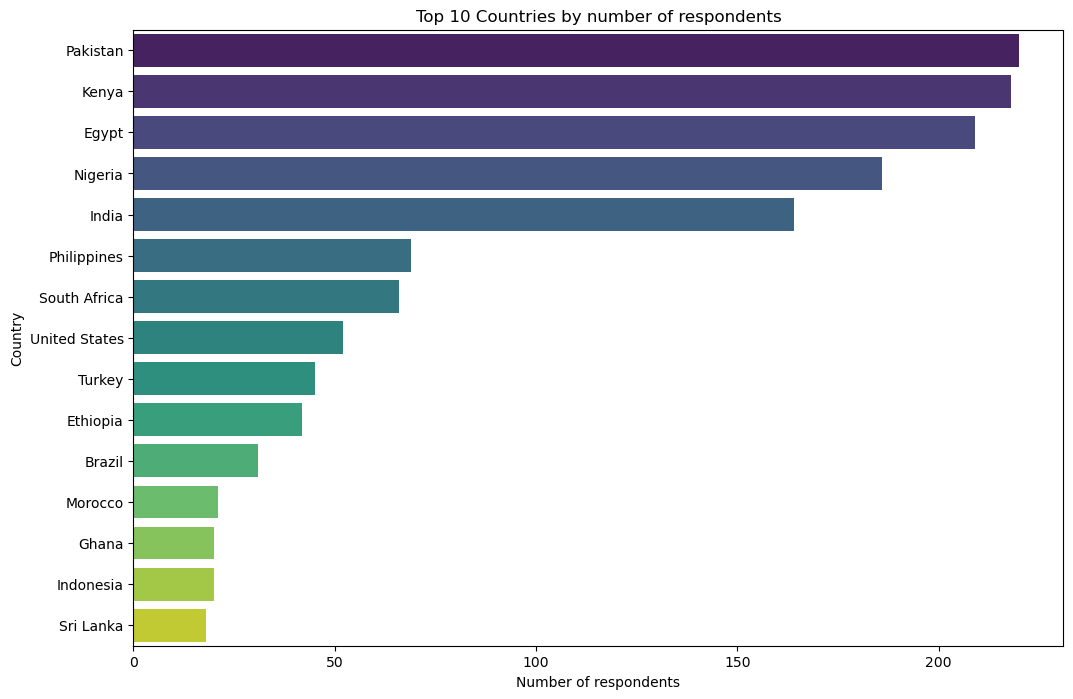

In [25]:
import seaborn as sns

country_counts = involved_users['country_name'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Select the top 10 countries
top_10_countries = country_counts.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='country', data=top_10_countries, palette='viridis')
plt.xlabel('Number of respondents')
plt.ylabel('Country')
plt.title('Top 10 Countries by number of respondents')
plt.show()


In [16]:
users.to_csv("users.csv")

In [17]:
# def prepare_voice_file(path: str) -> str:
#     """
#     Converts the input audio file to WAV format if necessary and returns the path to the WAV file.
#     """
#     if os.path.splitext(path)[1] == '.wav':
#         return path
#     elif os.path.splitext(path)[1] in ('.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp'): #('.mp3', '.m4a', '.ogg', '.flac', '.aac', '.wma'):
#         print(os.path.splitext(path)[1][1:])
#         audio_file = AudioSegment.from_file(
#             path, format=os.path.splitext(path)[1][1:])
#         wav_file = os.path.splitext(path)[0] + '.wav'
        
#         audio_file.export(wav_file, format='wav')
#         return wav_file
#     else:
#         raise ValueError(
#             f'Unsupported audio format: {format(os.path.splitext(path)[1])}')

def convert_to_wav (df):
    audio_extensions = ['.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp']
    for filename in df['file_path'] :
        # Get the file extension
        file_ext = os.path.splitext(filename)[1]
        # print (filename)
        # Check if the file has an audio extension
        if file_ext in audio_extensions:
            # New file path with .wav extension
            new_file = os.path.splitext(filename)[0] + '.wav'
            # Rename the file
            os.rename(filename, new_file)
            # print(f'Renamed "{filename}" to "{new_file}"')

In [18]:
from pydub.exceptions import CouldntDecodeError
def get_audio_duration(file_path):
    # print(file_path)
    try:
        audio = AudioSegment.from_file(file_path)
        return len(audio) / 1000.0  # duration in seconds
    except (CouldntDecodeError, IndexError):
        print("No duration extraction is available")
        print (file_path)
        return 0

def create_new_path(file_path):
    parts = file_path.rsplit('.', 1)
    return f"{parts[0]}-new.{parts[1]}"

def adjust_audio_duration(file_path, new_path, target_duration):
    audio = AudioSegment.from_file(file_path)
    while (len(audio) / 1000.0) < target_duration:
        audio += AudioSegment.from_file(file_path)  # Repeat the audio
    adjusted_audio = audio[:1000* target_duration]  # Cut any excess
    # print(new_path)
    # print(new_path.rsplit('.',1))
    adjusted_audio.export(new_path, format=new_path.rsplit('.',1)[1])

In [19]:
""" /Users/grigorijcebotarev/Desktop/thesis/Recordings/ """

' /Users/grigorijcebotarev/Desktop/thesis/Recordings/ '

In [20]:
import os
import glob

def get_file_extension(folder_path, file_name_without_extension):
    search_pattern = os.path.join(folder_path, file_name_without_extension + ".*")
    # Use glob to search for the file with the given pattern
    matching_files = glob.glob(search_pattern)
    if matching_files:
        # Extract the extension from the first matching file
        file_path = matching_files[0]
        _, file_extension = os.path.splitext(file_path)
        return file_extension
    else:
        return None 


In [21]:
base_audio_path = '/Users/grigorijcebotarev/Desktop/thesis/Recordings'
audio_extensions = ['.wav', '.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp']
for index, row in texts.iterrows():
    parts = row['INPUT:audio'].split("/")
    filename = parts[-1]
    texts.at[index, 'speechkit_path'] = os.path.join(base_audio_path, "texts_speechkit", filename)
    # Assume no valid file is found initially
    valid_audio_file_path = None
    # Check each extension to find a valid audio file
    for ext in audio_extensions:
        potential_path = os.path.join(base_audio_path, f"assignment_{row['ASSIGNMENT:assignment_id']}"+"/"+row['OUTPUT:recording'] + ext)
        if os.path.isfile(potential_path):
            valid_audio_file_path = potential_path
            break
    
    # If a valid audio file is found, process it
    if valid_audio_file_path: # and exten not in ['.mp4','.wma', '.amr', '.mpeg', '.opus', '.3gpp', '.aac']:
        texts.at[index, 'file_path'] = valid_audio_file_path
    else:
        texts.at[index, 'file_path'] = "None"
        # Добавить, какие типы файлов загружались?
        print(get_file_extension(os.path.join(base_audio_path, f"assignment_{row['ASSIGNMENT:assignment_id']}"),row['OUTPUT:recording']))
        # Optionally, append None or a placeholder if no valid audio file is found to maintain alignment
        # features_list.append("")
        # preferred_speeds.append("")  # Adjust as needed
        continue  # Skip the rest of the loop

.unknown
None
.png
.jpg
.jpg
.unknown
.mkv
.jpg
.png
.png
.docx
.jpg
.txt
.jpg
.jpg
.jpg
None
.xlsx
.jpg
.jpg
.exe
.html
.jpg
.jpg
.jpg
.jpg
.bmp
.jpg
.jpg
.jpg
.html
.png
None
None
.unknown
.jpg
.jpg
.jpg
.png
.txt
.jpg
.mkv
.vivaldi_reporting_data
.jpg
.pdf
.unknown
.webp
.png
.unknown
.jpg
.png
.jpg
.jpg
.bmp
.jpg
.jpg
.jpg
.png
.jpg
None
.jpg
.jpeg
.jpg
.jpg
.jpg
.html
.jpg
.png
.jpg
.jpg
None
.xlsx
.html
.jpg
.png
.jpg
.pdf
.jpg
None
.pdf
.jpg
.png
.png
.jpg
.jpg
.unknown
.jpg
.jpg
.jpeg
.txt
None
.png
.jpg
.png
.unknown
.jpg
None
None
.docx
.jpg
.jpg
.jpg
.png
.jpg
None
None
.jpg
.jpeg
None
.jpg
.exe
.png
.jpg
.jpg
.png
.jpg
.jpg
.jpg
.jpg
.mhtml
.jpg
.jpg
.html
None
.docx
.jpg
.jpg
.pdf
.jpg
.html
None
None
None
None
None
None
None
.exe
.jpg
None
.jpg
None
.jpg
None
.jpg
.jpg
.jpeg
.html
None
.png
.pdf
.jpg
.jpg
None
.docx
.png
.jpg
.jpg
.jpg
.pdf
.jpg
None


In [22]:
texts[texts['file_path'] == "None"]

INPUT:audio  \
554   https://storage.yandexcloud.net/toloka-chebota...   
592   https://storage.yandexcloud.net/toloka-chebota...   
601   https://storage.yandexcloud.net/toloka-chebota...   
604   https://storage.yandexcloud.net/toloka-chebota...   
621   https://storage.yandexcloud.net/toloka-chebota...   
...                                                 ...   
5014  https://storage.yandexcloud.net/toloka-chebota...   
5018  https://storage.yandexcloud.net/toloka-chebota...   
5035  https://storage.yandexcloud.net/toloka-chebota...   
5040  https://storage.yandexcloud.net/toloka-chebota...   
5048  https://storage.yandexcloud.net/toloka-chebota...   

                                            INPUT:image  \
554   https://storage.yandexcloud.net/toloka-chebota...   
592   https://storage.yandexcloud.net/toloka-chebota...   
601   https://storage.yandexcloud.net/toloka-chebota...   
604   https://storage.yandexcloud.net/toloka-chebota...   
621   https://storage.yandexcloud.net/toloka-chebota...   
...                                                 ...   
5014  https://storage.yandexcloud.net/toloka-chebota...   
5018  https://storage.yandexcloud.net/toloka-chebota...   
5035  https://storage.yandexcloud.net/toloka-chebota...   
5040  https://storage.yandexcloud.net/toloka-chebota...   
5048  https://storage.yandexcloud.net/toloka-chebota...   

                             OUTPUT:recording OUTPUT:result_3d_question  \
554   eu.7d92bc4d-37ea-43b4-a654-2636351e8a7a                        No   
592   eu.1aaed99e-10dd-40b5-a2c6-877f99ade2c6                       Yes   
601   eu.0c7a7f49-fcfd-41df-9561-8d70acb4b46c                        No   
604   eu.927961bc-53d1-425f-8b21-cf8b7f73fb9f                       Yes   
621   eu.e1199626-b401-4606-8c0a-bcfa08dc05c0                       Yes   
...                                       ...                       ...   
5014  eu.b8ffffc5-e66e-487b-9ae8-d7a9570a034e                       Yes   
5018  eu.414327c7-a812-4dd3-925d-d1450086ffa0                        No   
5035  eu.f0919832-184f-461f-a2a3-12b2c1fb7055                       Yes   
5040  eu.a2da283a-a0ff-413a-9cc0-5bcede37f8ba                       Yes   
5048  eu.1a8f1692-71d0-407a-a2bf-b9507f4d5297                       Yes   

     OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
554                         Yes                        Yes   
592                          No                        Yes   
601                         Yes                        Yes   
604                         Yes                         No   
621                         Yes                        Yes   
...                         ...                        ...   
5014                        Yes                        Yes   
5018                         No                         No   
5035                        Yes                        Yes   
5040                        Yes                        Yes   
5048                         No                        Yes   

     OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
554                          No  00028edf7c--661b97c3729d87695a3fe872   
592                          No  00028f9928--662bd260f81b996bc6149566   
601                         Yes  00028f9928--662bd2f1567f51718c8771ef   
604                         Yes  00028f9928--662bd308567f51718c877372   
621                          No  00028f9928--662bd49ccb201c62ab620e16   
...                         ...                                   ...   
5014                        Yes  00028ffbe7--664a2b33fb6c1e0937c7f9a7   
5018                        Yes  00028ffbe7--664aefbefb6c1e0937ce5de2   
5035                        Yes  00028ffbe7--664d3acf46643a735b789d52   
5040                        Yes  00028ffbe7--664e5afd30d6fd1d1c633bbf   
5048                        Yes  00028ffbe7--664f81a5db902752cf460a93   

                  ASSIGNMENT:worker_id  \
554   08d7db98e7b782b9b03bc12c080b1a1b   
592   037e0d0d1c7e7

In [23]:
texts = texts.drop(texts[texts['file_path'] == 'None'].index)

In [24]:
convert_to_wav(texts)

In [25]:
base_audio_path = '/Users/grigorijcebotarev/Desktop/thesis/Recordings'
audio_extensions = ['.wav', '.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp']
for index, row in texts.iterrows():
    # Assume no valid file is found initially
    valid_audio_file_path = None
    # Check each extension to find a valid audio file
    for ext in audio_extensions:
        potential_path = os.path.join(base_audio_path, f"assignment_{row['ASSIGNMENT:assignment_id']}"+"/"+row['OUTPUT:recording'] + ext)
        if os.path.isfile(potential_path):
            if (ext != '.wav'):
                print (ext)
            valid_audio_file_path = potential_path
            break
    
    # If a valid audio file is found, process it
    if valid_audio_file_path: # and exten not in ['.mp4','.wma', '.amr', '.mpeg', '.opus', '.3gpp', '.aac']:
        # print(index)
        texts.at[index, 'file_path'] = valid_audio_file_path
    else:
        texts.at[index, 'file_path'] = "None"
        # Optionally, append None or a placeholder if no valid audio file is found to maintain alignment
        # features_list.append("")
        # preferred_speeds.append("")  # Adjust as needed
        continue  # Skip the rest of the loop

In [26]:
texts['duration'] = texts['file_path'].apply(get_audio_duration)

No duration extraction is available
/Users/grigorijcebotarev/Desktop/thesis/Recordings/assignment_00028f9928--662cd781cb201c62ab74eb17/eu.daeb1783-9344-477c-9d5c-794d393d8564.wav
No duration extraction is available
/Users/grigorijcebotarev/Desktop/thesis/Recordings/assignment_00028fbd33--662fa091375e107843feba8a/eu.ae9f672e-44df-47e5-9849-3c8f1b2f3808.wav
No duration extraction is available
/Users/grigorijcebotarev/Desktop/thesis/Recordings/assignment_00028fbd33--662fa7e6faacc068763b7f41/eu.333a4ca2-c882-4925-94d6-03ef48367bb4.wav
No duration extraction is available
/Users/grigorijcebotarev/Desktop/thesis/Recordings/assignment_00028fbd33--6634d3182fff20106b747674/eu.f9e2b191-84a5-4c66-8250-b1b6452eaabc.wav
No duration extraction is available
/Users/grigorijcebotarev/Desktop/thesis/Recordings/assignment_00028ff54a--663f08d97f8a5f1c23193192/eu.a24d6922-fcd0-4373-91ea-844665ebe597.wav


In [27]:
texts[texts['duration'] == texts['duration'].max()]

INPUT:audio  \
770  https://storage.yandexcloud.net/toloka-chebota...   

                                           INPUT:image  \
770  https://storage.yandexcloud.net/toloka-chebota...   

                            OUTPUT:recording OUTPUT:result_3d_question  \
770  eu.4e88abf6-60e3-4f38-8695-aa03765bab13                       Yes   

    OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
770                        Yes                        Yes   

    OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
770                         No  00028f9928--662beadf375e107843c10423   

                 ASSIGNMENT:worker_id  \
770  3868b0745d83d0fbf166591cb2b651ee   

                                        speechkit_path  \
770  /Users/grigorijcebotarev/Desktop/thesis/Record...   

                                             file_path  duration  
770  /Users/grigorijcebotarev/Desktop/thesis/Record...   373.178

In [28]:
texts['duration'].nlargest(10)

770     373.178
1376    310.078
3564    180.535
957     127.818
691      99.798
2837     88.840
4021     80.940
4530     80.140
4012     79.520
3601     76.971
Name: duration, dtype: float64

In [29]:
texts['duration'].nsmallest(100)

1291     0.000
2102     0.000
2130     0.000
2389     0.000
3552     0.000
         ...  
4958    10.632
1451    10.656
1169    10.740
666     10.913
1255    11.060
Name: duration, Length: 100, dtype: float64

In [30]:
texts = texts.drop(texts[texts['duration'] <= 15.00].index)

In [31]:
largest_texts = texts.nlargest(10, 'duration')
largest_texts

INPUT:audio  \
770   https://storage.yandexcloud.net/toloka-chebota...   
1376  https://storage.yandexcloud.net/toloka-chebota...   
3564  https://storage.yandexcloud.net/toloka-chebota...   
957   https://storage.yandexcloud.net/toloka-chebota...   
691   https://storage.yandexcloud.net/toloka-chebota...   
2837  https://storage.yandexcloud.net/toloka-chebota...   
4021  https://storage.yandexcloud.net/toloka-chebota...   
4530  https://storage.yandexcloud.net/toloka-chebota...   
4012  https://storage.yandexcloud.net/toloka-chebota...   
3601  https://storage.yandexcloud.net/toloka-chebota...   

                                            INPUT:image  \
770   https://storage.yandexcloud.net/toloka-chebota...   
1376  https://storage.yandexcloud.net/toloka-chebota...   
3564  https://storage.yandexcloud.net/toloka-chebota...   
957   https://storage.yandexcloud.net/toloka-chebota...   
691   https://storage.yandexcloud.net/toloka-chebota...   
2837  https://storage.yandexcloud.net/toloka-chebota...   
4021  https://storage.yandexcloud.net/toloka-chebota...   
4530  https://storage.yandexcloud.net/toloka-chebota...   
4012  https://storage.yandexcloud.net/toloka-chebota...   
3601  https://storage.yandexcloud.net/toloka-chebota...   

                             OUTPUT:recording OUTPUT:result_3d_question  \
770   eu.4e88abf6-60e3-4f38-8695-aa03765bab13                       Yes   
1376  eu.ac21bfae-1682-41e4-8be9-b511c10f67ff                       Yes   
3564  eu.7222c282-1ac1-4ccd-9ca6-2943e7bbfc66                       Yes   
957   eu.7c14b960-fd02-4eb8-9dc4-99b794c912de                        No   
691   eu.82c798a8-af7e-4080-8e94-20ae36a04ede                       Yes   
2837  eu.9fd5be1c-1910-47f0-940a-e76f16db516f         None of the above   
4021  eu.8b16bc32-4d43-4937-ab7b-81b5d6a4a939                       Yes   
4530  eu.b82e30d0-b65a-427e-b032-ca841367a02a         None of the above   
4012  eu.3e7d77c9-0bf0-460a-8686-1c5aa6633cae                       Yes   
3601  eu.20377267-72fa-4839-bce0-254fc62e7a71                       Yes   

     OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
770                         Yes                        Yes   
1376                        Yes                        Yes   
3564                         No                         No   
957                          No                        Yes   
691                         Yes                        Yes   
2837                         No                         No   
4021                         No                        Yes   
4530                         No                         No   
4012                         No                        Yes   
3601                        Yes                        Yes   

     OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
770                          No  00028f9928--662beadf375e107843c10423   
1376                        Yes  00028f9928--662cf2dbf81b996bc629be22   
3564                         No  00028ff54a--663f25b918b3266e286f6e14   
957                          No  00028f9928--662c319bcb201c62ab6975e5   
691                         Yes  00028f9928--662bdcacf6eb632909e8b195   
2837          None of the above  00028f1722--661be4d8495e7d730e4bcca2   
4021                         No  00028f783b--66290c0dc56ff768338322aa   
4530          None of the above  00028f783b--662d18f6567f51718c9db4c8   
4012                         No  00028f783b--66290af650de4e597ce6817f   
3601                         No  00028ff54a--663f8c30a6811748becbc7ed   

                  ASSIGNMENT:worker_id  \
770   3868b0745d83d0fbf166591cb2b651ee   
1376  9dbaa372523e6805d03c078acdb11dc9   
3564  daa441c0edae2068a5ce3b62e30b7e1e   
957   aee397ac87fb80a6d9ced6fe70f067dc   
691   09537fe0c31a3f7cba968a9363230eb2   
2837  47f5af2a67a2bbd16e116ded0af308d9   
4021  47f5af2a67a2bbd16e116ded0af308d9   
4530  47f5af2a67a2bbd16e116ded0af308d9   
4012  47f5af2a67a2bbd16e116ded0af308d9   
3601  49fec

In [32]:
texts = texts.drop(texts[texts['duration'] > 90.00].index)

In [33]:
texts['new_path'] = texts['file_path'].apply(create_new_path)
texts['new_speechkit_path'] = texts['speechkit_path'].apply(create_new_path)

In [35]:
max_duration = texts['duration'].max()
for index, row in texts.iterrows():
    if row['duration'] < max_duration:
        adjust_audio_duration(row['file_path'], row['new_path'], max_duration)
        adjust_audio_duration(row['speechkit_path'], row['new_speechkit_path'], max_duration)

In [36]:
t = []
for index, row in texts.iterrows():
    parts = row['INPUT:image'].split("/")
    filename = parts[-1]
    number = int(filename.split(".")[0])
    t.append(number)
texts['assigned_text'] = t

In [37]:
texts

INPUT:audio  \
0     https://storage.yandexcloud.net/toloka-chebota...   
1     https://storage.yandexcloud.net/toloka-chebota...   
2     https://storage.yandexcloud.net/toloka-chebota...   
3     https://storage.yandexcloud.net/toloka-chebota...   
4     https://storage.yandexcloud.net/toloka-chebota...   
...                                                 ...   
5042  https://storage.yandexcloud.net/toloka-chebota...   
5044  https://storage.yandexcloud.net/toloka-chebota...   
5045  https://storage.yandexcloud.net/toloka-chebota...   
5046  https://storage.yandexcloud.net/toloka-chebota...   
5047  https://storage.yandexcloud.net/toloka-chebota...   

                                            INPUT:image  \
0     https://storage.yandexcloud.net/toloka-chebota...   
1     https://storage.yandexcloud.net/toloka-chebota...   
2     https://storage.yandexcloud.net/toloka-chebota...   
3     https://storage.yandexcloud.net/toloka-chebota...   
4     https://storage.yandexcloud.net/toloka-chebota...   
...                                                 ...   
5042  https://storage.yandexcloud.net/toloka-chebota...   
5044  https://storage.yandexcloud.net/toloka-chebota...   
5045  https://storage.yandexcloud.net/toloka-chebota...   
5046  https://storage.yandexcloud.net/toloka-chebota...   
5047  https://storage.yandexcloud.net/toloka-chebota...   

                             OUTPUT:recording OUTPUT:result_3d_question  \
0     eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249                        No   
1     eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a                       Yes   
2     eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b                        No   
3     eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba                        No   
4     eu.440419a1-a930-4eb2-b965-fb45c69df94e                        No   
...                                       ...                       ...   
5042  eu.7fcdde19-4b38-4a44-8dc7-a0c68ebb2d06                        No   
5044  eu.3569cba1-8e98-475a-84fe-971b0dc4c7e9                        No   
5045  eu.2b5ec51b-70d7-4031-b831-afe54060cc27                        No   
5046  eu.a9b263c4-ca44-4fcd-8bb5-dda675a82550         None of the above   
5047  eu.1b1c26dc-3c87-4e71-ab4f-e3019d6ed609                       Yes   

     OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
0                            No                         No   
1                           Yes                         No   
2                            No                         No   
3                            No                        Yes   
4                            No                         No   
...                         ...                        ...   
5042                         No                        Yes   
5044                        Yes                        Yes   
5045                         No                        Yes   
5046                        Yes                        Yes   
5047                        Yes                        Yes   

     OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
0                            No  00028edf7c--6613eacdecfe467e31a1b8cb   
1                            No  00028edf7c--6613ead849336b29782c831c   
2                            No  00028edf7c--6613eaf349336b29782c8615   
3                           Yes  00028edf7c--6613eb144e5be33a301bfdde   
4                            No  00028edf7c--6613eb6d4e5be33a301c075d   
...                         ...                                   ...   
5042                        Yes  00028ffbe7--664f07bb42ac8f441d6bf968   
5044                        Yes  00028ffbe7--664f3cb542ac8f441d6f43be   
5045                        Yes  00028ffbe7--664f4f6cdb902752cf421fd8   
5046          None of the above  00028ffbe7--664f6669db902752cf442474   
5047                         No  00028ffbe7--664f70bd42ac8f441d74413b   

                  ASSIGNMENT:worker_id  \
0     b2c2c06f6bf8eed800e25881029fbcf7   
1     6a77f4ba1d045

In [38]:
texts.to_csv('texts.csv', index = False)

# THE REST CODE IS NOT NEEDED IN THIS PARTICULAR FILE (TO CHECK)


In [ ]:
mfcc_features = []
spectral_centroid_features = []
spectral_rolloff_features = []
zcr_features = []
chroma_features = []
tonality_features = []
time_domain_features = []

for audio_data in adjusted_audio_data:
    mfcc = librosa.feature.mfcc(y=audio_data)
    mfcc_features.append(mfcc)

    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data)
    spectral_centroid_features.append(spectral_centroid)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data)
    spectral_rolloff_features.append(spectral_rolloff)

    zcr = librosa.feature.zero_crossing_rate(y=audio_data)
    zcr_features.append(zcr)

    chroma = librosa.feature.chroma_cens(y=audio_data)
    chroma_features.append(chroma)

In [22]:
# compute Levenshtein distance
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

In [11]:
"""
# !pip install toloka-kit
import toloka.client

toloka_client = toloka.client.TolokaClient(
  'T13G0USVrAJlXKx4VmjHlA.045e.157M3UiypS9H4MuCrRyOGLpAoHB0LQ9AAE6vZFcLeN8he6cYVsKU2Ne9XJuHJbzi7IJOlHEJxCynEXIC8sHWG_xiL626rBDkVLlJEXzWzsA', 'PRODUCTION')

user = toloka_client.get_user('8dd2a57d792e2af44e514ed9c8e6ed92')
#print(user.country, user.attributes.device_category)
print (user)
""""


User(_unexpected={}, id='8dd2a57d792e2af44e514ed9c8e6ed92', country='TR', languages=['AF', 'DE', 'EN', 'ES', 'NL', 'TR'], adult_allowed=True, attributes=User.Attributes(_unexpected={}, country_by_phone='TR', country_by_ip='NL', client_type='BROWSER', user_agent_type='BROWSER', device_category='PERSONAL_COMPUTER', os_family='WINDOWS', os_version=10.0, os_version_major=10, os_version_minor=0, os_version_bugfix=0))


In [26]:
import os
import speech_recognition as sr
from pydub import AudioSegment


def prepare_voice_file(path: str) -> str:
    
    """
    Converts the input audio file to WAV format if necessary and returns the path to the WAV file.
    """
    if os.path.splitext(path)[1] == '.wav':
        return path
    elif os.path.splitext(path)[1] in ('.mp3', '.m4a', '.ogg', '.flac') :
        audio_file = AudioSegment.from_file(
            path, format=os.path.splitext(path)[1][1:])
        wav_file = os.path.splitext(path)[0] + '.wav'
        audio_file.export(wav_file, format='wav')
        return wav_file
    else:
        raise ValueError(
            f'Unsupported audio format: {format(os.path.splitext(path)[1])}')


def transcribe_audio(audio_data, language) -> str:
    """
    Transcribes audio data to text using Google's speech recognition API.
    """
    r = sr.Recognizer()
    text = r.recognize_google(audio_data, language=language)
    return text


def write_transcription_to_file(text, output_file) -> None:
    """
    Writes the transcribed text to the output file.
    """
    with open(output_file, 'w') as f:
        f.write(text)


def speech_to_text(input_path: str, language: str) -> None:
    """
    Transcribes an audio file at the given path to text and writes the transcribed text to the output file.
    """
   #wav_file = prepare_voice_file(input_path)
    with sr.AudioFile(input_path) as source:
        audio_data = sr.Recognizer().record(source)
        text = transcribe_audio(audio_data, language)
        
        #dataframe.loc[index, 'text_transcription'] = text
        # write_transcription_to_file(text, output_path)
        # print('Transcription:')
        # print(text)
    return text


# if __name__ == '__main__':
#     #print('Please enter the path to an audio file (WAV, MP3, M4A, OGG, or FLAC):')
#     #input_path = input().strip()
#     if not os.path.isfile(input_path):
#         print('Error: File not found.')
#         exit(1)
#     else:
#         # print('Please enter the path to the output file:')
#         # output_path = input().strip()
#         # print('Please enter the language code (e.g. en-US):')
#         language = "en-US"
#         try:
#             speech_to_text(input_path, output_path, language)
#         except Exception as e:
#             print('Error:', e)
#             exit(1)


In [10]:
import speech_recognition as sr
from pydub import AudioSegment
from speech_recognition import UnknownValueError, RequestError


def transcribe_audio(file_path):
    # Load audio file
    audio = AudioSegment.from_file(file_path)
    
    # Convert stereo to mono (if needed)
    if audio.channels == 2:
        audio = audio.set_channels(1)
    
    # Initialize recognizer
    recognizer = sr.Recognizer()
    
    # Convert audio to raw data
    with sr.AudioFile(file_path) as source:
        audio_data = recognizer.record(source)
    
    # Perform speech recognition
    try:
        transcribed_text = recognizer.recognize_google(audio_data)
        print ("Success!")
        return transcribed_text
    except (sr.UnknownValueError, UnknownValueError,EOFError, ValueError,NameError):
        print (file_path)
        return "Unable to transcribe"
    except sr.RequestError as e:
        print (file_path)
        return f"Error: {e}"



In [11]:
texts['transcribed_text'] = texts['file_path'].apply(transcribe_audio)

Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
/Users/grigorijcebotarev/Desktop/thesis/Recordings/assignment_00028edf7c--6613edfdde86a15063766ce1/eu.f1cad6b5-ab37-4f09-8343-4500caba2c3e.wav
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!


ValueError: Audio file could not be read as PCM WAV, AIFF/AIFF-C, or Native FLAC; check if file is corrupted or in another format

In [20]:
from speech_recognition import UnknownValueError
for index, row in texts.iterrows():
    try:
        texts.at[index, 'text_transcription'] = speech_to_text(row['file_path'], "en-US")
    except (UnknownValueError, ValueError, TypeError):
        print(index)

38
70
243
280
288
294
306
307
308
309
312
316
317
318
322
331
332
333
334
342
345
346
347
348
349
352
353
356
357
361
365
367
374
378
379
380
381
382
383
385
386
387
389
394
396
397
400
401
403
407
410
413
414
416
429
431
433
435
436
437
438
441
442
446
447
450
451
456
457
461
462
468
469
472
474
475
476
479
482
483
484
487
493
496
498
501
504
505
506
510
511
514
518
519
520
521
525
530
531
532
535
537
539
542
545
549
568
573
574
586
589
594
598
608
610
617
618
621
627
636
637
638
639
642
644
649
653
656
659
668
672
677
678
685
686
698
699
700
709
712
713
714
716
718
723
729
734
735
738
741
744
746
748
749
753
754
757
758
760
761
767
768
770
776
780
781
782
785
789
794
802
803
820
825
828
837
840
842
843
844
849
851
853
854
856
861
868
870
871
873
874
880
890
898
902
911
912
915
923
929
936
937
944
949
953
959
963
971
976
982
986
987
993
1000
1003
1020
1021
1022
1032
1035
1038
1039
1040
1043
1048
1051
1058
1059
1066
1069
1070
1072
1076
1077
1080
1082
1090
1093
1102
1105
1109
1112
1117


In [43]:
# texts.drop(38, inplace = True)
# texts.drop(70, inplace = True)
# texts.drop(149, inplace = True)
# texts.drop(281, inplace = True)

In [ ]:
texts.to_csv("googlespeech.csv")

In [1]:
base_audio_path = '/Users/grigorijcebotarev/Desktop/untitled folder/Recordings'
audio_extensions = ['.wav', '.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp']
for index, row in texts.iterrows():
    # Assume no valid file is found initially
    valid_audio_file_path = None
    exten = ""
    # Check each extension to find a valid audio file
    for ext in audio_extensions:
        potential_path = os.path.join(base_audio_path, f"assignment_{row['ASSIGNMENT:assignment_id']}"+"/"+row['OUTPUT:recording'] + ext)
        if os.path.isfile(potential_path):
            exten = ext
            valid_audio_file_path = potential_path
            break
    
    # If a valid audio file is found, process it
    if valid_audio_file_path and exten not in ['.mp4','.wma', '.amr', '.mpeg', '.opus', '.3gpp', '.aac']:
        # Extract audio features
        # recording, sr = librosa.load(valid_audio_file_path)
        # features_recording = extract_audio_features(recording, sr)
        # speechkit_recording, _ = librosa.load(row['INPUT:audio'][50:])
        # features_speechkit = extract_audio_features(speechkit_recording, sr, name = " " + row['INPUT:audio'][50:])
        # features = pd.concat([features_recording, features_speechkit], axis = 1)
        print(index)
        texts.loc[index, 'text_transcription'] = speech_to_text(valid_audio_file_path, "en-US")
        # features_list.append(np.append(mfccs, zcr))
    else:
        # Optionally, append None or a placeholder if no valid audio file is found to maintain alignment
        # features_list.append("")
        # preferred_speeds.append("")  # Adjust as needed
        continue  # Skip the rest of the loop


'\nbase_audio_path = \'/Users/grigorijcebotarev/Desktop/untitled folder/Recordings\'\naudio_extensions = [\'.wav\', \'.m4a\', \'.mp4\', \'.aac\',\'.mp3\',\'.wma\', \'.ogg\', \'.amr\', \'.mpeg\', \'.opus\', \'.3gpp\']\nfor index, row in texts.iterrows():\n    # Assume no valid file is found initially\n    valid_audio_file_path = None\n    exten = ""\n    # Check each extension to find a valid audio file\n    for ext in audio_extensions:\n        potential_path = os.path.join(base_audio_path, f"assignment_{row[\'ASSIGNMENT:assignment_id\']}"+"/"+row[\'OUTPUT:recording\'] + ext)\n        if os.path.isfile(potential_path):\n            exten = ext\n            valid_audio_file_path = potential_path\n            break\n    \n    # If a valid audio file is found, process it\n    if valid_audio_file_path and exten not in [\'.mp4\',\'.wma\', \'.amr\', \'.mpeg\', \'.opus\', \'.3gpp\', \'.aac\']:\n        # Extract audio features\n        # recording, sr = librosa.load(valid_audio_file_path)\n  

In [48]:
FRAME_SIZE = 1024
HOP_LENGTH = 512

In [9]:
levenstein = texts.loc[0:305]
levenstein

INPUT:audio  \
0    https://storage.yandexcloud.net/toloka-chebota...   
1    https://storage.yandexcloud.net/toloka-chebota...   
2    https://storage.yandexcloud.net/toloka-chebota...   
3    https://storage.yandexcloud.net/toloka-chebota...   
4    https://storage.yandexcloud.net/toloka-chebota...   
..                                                 ...   
301  https://storage.yandexcloud.net/toloka-chebota...   
302  https://storage.yandexcloud.net/toloka-chebota...   
303  https://storage.yandexcloud.net/toloka-chebota...   
304  https://storage.yandexcloud.net/toloka-chebota...   
305  https://storage.yandexcloud.net/toloka-chebota...   

                                           INPUT:image  \
0    https://storage.yandexcloud.net/toloka-chebota...   
1    https://storage.yandexcloud.net/toloka-chebota...   
2    https://storage.yandexcloud.net/toloka-chebota...   
3    https://storage.yandexcloud.net/toloka-chebota...   
4    https://storage.yandexcloud.net/toloka-chebota...   
..                                                 ...   
301  https://storage.yandexcloud.net/toloka-chebota...   
302  https://storage.yandexcloud.net/toloka-chebota...   
303  https://storage.yandexcloud.net/toloka-chebota...   
304  https://storage.yandexcloud.net/toloka-chebota...   
305  https://storage.yandexcloud.net/toloka-chebota...   

                            OUTPUT:recording OUTPUT:result_3d_question  \
0    eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249                        No   
1    eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a                       Yes   
2    eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b                        No   
3    eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba                        No   
4    eu.440419a1-a930-4eb2-b965-fb45c69df94e                        No   
..                                       ...                       ...   
301  eu.15d722b9-dd0a-48c6-8fbf-56706f408a3b         None of the above   
302  eu.c9e970f4-3621-460d-afd7-7e94f475a4e7                       Yes   
303  eu.1af33a6e-011c-4cae-920d-81278040de17                        No   
304  eu.c56bead3-0970-4774-b5e2-63211596708b                        No   
305  eu.8033ff2a-ce94-4a1e-ac6a-2bc4546b0f9d                        No   

    OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
0                           No                         No   
1                          Yes                         No   
2                           No                         No   
3                           No                        Yes   
4                           No                         No   
..                         ...                        ...   
301                         No                        Yes   
302                         No                        Yes   
303                        Yes                        Yes   
304                         No                         No   
305                         No                        Yes   

    OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
0                           No  00028edf7c--6613eacdecfe467e31a1b8cb   
1                           No  00028edf7c--6613ead849336b29782c831c   
2                           No  00028edf7c--6613eaf349336b29782c8615   
3                          Yes  00028edf7c--6613eb144e5be33a301bfdde   
4                           No  00028edf7c--6613eb6d4e5be33a301c075d   
..                         ...                                   ...   
301          None of the above  00028edf7c--66141cfa49336b297831e313   
302                         No  00028edf7c--66141da5ecfe467e31a6f12e   
303                         No  00028edf7c--66141ddd49336b297831fb96   
304                         No  00028edf7c--66141de1de86a150637b2f91   
305                        Yes  00028edf7c--66141ecf49336b2978321207   

                 ASSIGNMENT:worker_id  1_mffcs_coeff_mean  ...  \
0    b2c2c06f6bf8eed800e25881029fbcf7         -408.419373  ...   
1    6a77f4ba1d04551c0c776dbd7

In [4]:
text_A = pd.read_csv("TextA.tsv", sep='\t')

In [5]:
text_A = text_A.drop(['GOLDEN:result_3d_question', 'GOLDEN:result_1st_question', 
             'GOLDEN:result_2nd_question', 'GOLDEN:result_4th_question', 
             'HINT:text', 'HINT:default_language', 
             'ASSIGNMENT:status',
             'ASSIGNMENT:started', 'ACCEPT:verdict', 'ACCEPT:comment',
             'ASSIGNMENT:link','ASSIGNMENT:task_id'], axis = 1)
# 'ASSIGNMENT:assignment_id'
text_A.head(2)

INPUT:audio  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   

                                         INPUT:image  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   

                          OUTPUT:recording OUTPUT:result_3d_question  \
0  eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249                        No   
1  eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a                       Yes   

  OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
0                         No                         No   
1                        Yes                         No   

  OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
0                         No  00028edf7c--6613eacdecfe467e31a1b8cb   
1                         No  00028edf7c--6613ead849336b29782c831c   

               ASSIGNMENT:worker_id  
0  b2c2c06f6bf8eed800e25881029fbcf7  
1  6a77f4ba1d04551c0c776dbd7b38e2f5

In [6]:
text_B = pd.read_csv("TextB.tsv", sep='\t')

In [7]:
text_B = text_B.drop(['GOLDEN:result_3d_question', 'GOLDEN:result_1st_question', 
             'GOLDEN:result_2nd_question', 'GOLDEN:result_4th_question', 
             'HINT:text', 'HINT:default_language', 
              'ASSIGNMENT:status',
             'ASSIGNMENT:started', 'ACCEPT:verdict', 'ACCEPT:comment',
             'ASSIGNMENT:link','ASSIGNMENT:task_id'], axis = 1)
# 'ASSIGNMENT:assignment_id'
text_B.head(2)

INPUT:audio  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   

                                         INPUT:image  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   

                          OUTPUT:recording OUTPUT:result_3d_question  \
0  eu.3db8cd37-3747-4fd5-9064-8350a4a82b6d                        No   
1  eu.89ebd82e-f874-4436-aebb-68f670dd872f                        No   

  OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
0                         No                        Yes   
1                        Yes                         No   

  OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
0                        Yes  00028ee7dd--6616d907af58cc72313427c1   
1                        Yes  00028ee7dd--6616d90baf58cc7231342816   

               ASSIGNMENT:worker_id  
0  19693f26e3c3a13e1d90699b3ced25e5  
1  f0544608d33b1d21fa8b83c274b7edfc

In [8]:
text_C = pd.read_csv("TextC.tsv", sep='\t')
text_C = text_C.drop(['GOLDEN:result_3d_question', 'GOLDEN:result_1st_question', 
             'GOLDEN:result_2nd_question', 'GOLDEN:result_4th_question', 
             'HINT:text', 'HINT:default_language', 
              'ASSIGNMENT:status',
             'ASSIGNMENT:started', 'ACCEPT:verdict', 'ACCEPT:comment',
             'ASSIGNMENT:link','ASSIGNMENT:task_id'], axis = 1)
# 'ASSIGNMENT:assignment_id'
text_C.head(2)

INPUT:audio  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   

                                         INPUT:image  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   

                          OUTPUT:recording OUTPUT:result_3d_question  \
0  eu.4bed2b58-81d5-4ddd-bbf5-9d87c4677640                        No   
1  eu.5e0cb047-0e1c-4eb1-b7cf-ee0ccfc16a48                        No   

  OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
0                         No                         No   
1                        Yes                        Yes   

  OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
0                         No  00028f1722--661bd4a8495e7d730e4af08f   
1                         No  00028f1722--661bd4aca2c3420070518266   

               ASSIGNMENT:worker_id  
0  6cf33e427bb91382aca184e27098afdc  
1  e91724d5d076b3288e83b05b4372d2d8

In [49]:
def extract_audio_features(signal, sample_rate,frame_size = FRAME_SIZE, hop_size = HOP_LENGTH, name = ""):
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sample_rate)
    mean_mfccs = np.mean(mfccs, axis=1)
    delta_mfccs = librosa.feature.delta(mfccs)
    mean_delta_mfccs = np.mean(delta_mfccs, axis=1)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    mean_delta2_mfccs = np.mean(delta2_mfccs, axis=1)
    zero_crossings = librosa.feature.zero_crossing_rate(signal)
    mean_zero_crossings = np.mean(zero_crossings)
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    delta1 = pd.DataFrame(mean_delta_mfccs).T
    delta1 = delta1.rename(columns={    0: "1_delta_coeff_mean" + name, 
                                        1: "2_delta_coeff_mean" + name,
                                        2: "3_delta_coeff_mean" + name,
                                        3: "4_delta_coeff_mean" + name,
                                        4: "5_delta_coeff_mean" + name,
                                        5: "6_delta_coeff_mean" + name,
                                        6: "7_delta_coeff_mean" + name, 
                                        7: "8_delta_coeff_mean" + name,
                                        8: "9_delta_coeff_mean" + name,
                                        9: "10_delta_coeff_mean" + name,
                                        10: "11_delta_coeff_mean" + name,
                                        11: "12_delta_coeff_mean" + name,
                                        12: "13_delta_coeff_mean" + name})
    delta2 = pd.DataFrame(mean_delta2_mfccs).T
    delta2 = delta2.rename(columns={    0: "1_delta2_coeff_mean" + name, 
                                        1: "2_delta2_coeff_mean" + name,
                                        2: "3_delta2_coeff_mean" + name,
                                        3: "4_delta2_coeff_mean" + name,
                                        4: "5_delta2_coeff_mean" + name,
                                        5: "6_delta2_coeff_mean" + name,
                                        6: "7_delta2_coeff_mean" + name,
                                        7: "8_delta2_coeff_mean" + name,
                                        8: "9_delta2_coeff_mean" + name,
                                        9: "10_delta2_coeff_mean" + name,
                                        10: "11_delta2_coeff_mean" + name,
                                        11: "12_delta2_coeff_mean" + name,
                                        12: "13_delta2_coeff_mean" + name})
    mfcss = pd.DataFrame(mean_mfccs).T
    mfcss = mfcss.rename(columns={      0: "1_mffcs_coeff_mean" + name, 
                                        1: "2_mffcs_coeff_mean" + name,
                                        2: "3_mffcs_coeff_mean" + name,
                                        3: "4_mffcs_coeff_mean" + name,
                                        4: "5_mfccs_coeff_mean" + name,
                                        5: "6_mffcs_coeff_mean" + name,
                                        6: "7_mffcs_coeff_mean" + name,
                                        7: "8_mffcs_coeff_mean" + name,
                                        8: "9_mffcs_coeff_mean" + name,
                                        9: "10_mffcs_coeff_mean" + name,
                                        10: "11_mffcs_coeff_mean" + name,
                                        11: "12_mffcs_coeff_mean" + name,
                                        12: "13_mffcs_coeff_mean" + name})
    mfcss['zero_crossings_mean' + name] = mean_zero_crossings
    mfcss['spectral_centroid_mean' + name] = np.mean(spectral_centroid)
    mfcss['spectral_bandwidth_mean' + name] = np.mean(spectral_bandwidth)
    features = pd.concat([mfcss, delta1,delta2], axis = 1)
    return features

In [11]:
debussy_file = "temp.wav"
ipd.Audio(debussy_file)

In [12]:
debussy, sr = librosa.load(debussy_file)

In [13]:
mfccs = extract_audio_features(debussy, sr, name = " Text_A")

In [14]:
mfccs.shape
# mfccs= np.mean(mfccs, axis=1)

(1, 42)

### Checking that the audiofile is attached

In [15]:
# Base path to the audio folders
texts= pd.concat([text_A, text_B, text_C])
texts = texts.reset_index(drop=True)
base_audio_path = "/Users/grigorijcebotarev/Desktop/untitled folder/Recordings"

In [16]:
texts.head()

INPUT:audio  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   
2  https://storage.yandexcloud.net/toloka-chebota...   
3  https://storage.yandexcloud.net/toloka-chebota...   
4  https://storage.yandexcloud.net/toloka-chebota...   

                                         INPUT:image  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   
2  https://storage.yandexcloud.net/toloka-chebota...   
3  https://storage.yandexcloud.net/toloka-chebota...   
4  https://storage.yandexcloud.net/toloka-chebota...   

                          OUTPUT:recording OUTPUT:result_3d_question  \
0  eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249                        No   
1  eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a                       Yes   
2  eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b                        No   
3  eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba                        No   
4  eu.440419a1-a930-4eb2-b965-fb45c69df94e                        No   

  OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
0                         No                         No   
1                        Yes                         No   
2                         No                         No   
3                         No                        Yes   
4                         No                         No   

  OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
0                         No  00028edf7c--6613eacdecfe467e31a1b8cb   
1                         No  00028edf7c--6613ead849336b29782c831c   
2                         No  00028edf7c--6613eaf349336b29782c8615   
3                        Yes  00028edf7c--6613eb144e5be33a301bfdde   
4                         No  00028edf7c--6613eb6d4e5be33a301c075d   

               ASSIGNMENT:worker_id  
0  b2c2c06f6bf8eed800e25881029fbcf7  
1  6a77f4ba1d04551c0c776dbd7b38e2f5  
2  6e9fdeeb3d0dfb1afd888aa5c8d347e6  
3  f91d95a62d1c07da5f4ddae20e7e6b14  
4  6de9d807930d55fdddfaf3eecd0c8c13

In [64]:
audio_extensions = ['.wav', '.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp']

# Iterate over the rows in the dataframe
for index, row in texts.iterrows():
    # Assume no valid file is found initially
    valid_audio_file_path = None
    # Check each extension to find a valid audio file
    for ext in audio_extensions:
        potential_path = os.path.join(base_audio_path, f"assignment_{row['ASSIGNMENT:assignment_id']}"+"/"+row['OUTPUT:recording'] + ext)
        if os.path.isfile(potential_path):
            valid_audio_file_path = potential_path
            break
    
    # If a valid audio file is found, process it
    if valid_audio_file_path:
        # Extract audio features
        recording, sr = librosa.load(valid_audio_file_path)
        features_recording = extract_audio_features(recording, sr)
        speechkit_recording, _ = librosa.load(row['INPUT:audio'][50:])
        features_speechkit = extract_audio_features(speechkit_recording, sr, name = "_speechkit_text")
        features = pd.concat([features_recording, features_speechkit], axis = 1)
        texts.loc[index, features.columns] = features.iloc[0]
        # features_list.append(np.append(mfccs, zcr))
    else:
        # Optionally, append None or a placeholder if no valid audio file is found to maintain alignment
        # features_list.append("")
        # preferred_speeds.append("")  # Adjust as needed
        continue  # Skip the rest of the loop


In [ ]:
texts[texts['1_mffcs_coeff_mean'].isna()]

In [ ]:
texts.dropna(inplace = True)
texts = texts.reset_index(drop=True)

In [18]:
texts = pd.read_csv('texts.csv')

### Computing Levenstein Distance

In [19]:
def get_text_number(df):
    for index, row in df.iterrows():
        # Split the link by '/' and extract the last part
        link = row['INPUT:image']
        parts = link.split("/")
        filename = parts[-1]
        number = filename.split(".")[0]
        value = int(number)
        df.loc[index, 'text_number'] = value

In [16]:
get_text_number(texts)

In [17]:
texts

INPUT:audio  \
0     https://storage.yandexcloud.net/toloka-chebota...   
1     https://storage.yandexcloud.net/toloka-chebota...   
2     https://storage.yandexcloud.net/toloka-chebota...   
3     https://storage.yandexcloud.net/toloka-chebota...   
4     https://storage.yandexcloud.net/toloka-chebota...   
...                                                 ...   
1979  https://storage.yandexcloud.net/toloka-chebota...   
1980  https://storage.yandexcloud.net/toloka-chebota...   
1981  https://storage.yandexcloud.net/toloka-chebota...   
1982  https://storage.yandexcloud.net/toloka-chebota...   
1983  https://storage.yandexcloud.net/toloka-chebota...   

                                            INPUT:image  \
0     https://storage.yandexcloud.net/toloka-chebota...   
1     https://storage.yandexcloud.net/toloka-chebota...   
2     https://storage.yandexcloud.net/toloka-chebota...   
3     https://storage.yandexcloud.net/toloka-chebota...   
4     https://storage.yandexcloud.net/toloka-chebota...   
...                                                 ...   
1979  https://storage.yandexcloud.net/toloka-chebota...   
1980  https://storage.yandexcloud.net/toloka-chebota...   
1981  https://storage.yandexcloud.net/toloka-chebota...   
1982  https://storage.yandexcloud.net/toloka-chebota...   
1983  https://storage.yandexcloud.net/toloka-chebota...   

                             OUTPUT:recording OUTPUT:result_3d_question  \
0     eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249                        No   
1     eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a                       Yes   
2     eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b                        No   
3     eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba                        No   
4     eu.440419a1-a930-4eb2-b965-fb45c69df94e                        No   
...                                       ...                       ...   
1979  eu.a15477f0-571b-44ca-80ed-53f5a43afd54                       Yes   
1980  eu.32cf8985-e037-4da6-943b-aaa902d86fce                        No   
1981  eu.79f959fa-a50f-4488-a717-66b551d0e7a5                       Yes   
1982  eu.dd03e85c-7f70-463e-9622-3565df3f9408                       Yes   
1983  eu.9a4696bb-65d5-429c-babd-0bedfd792c9e                        No   

     OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
0                            No                         No   
1                           Yes                         No   
2                            No                         No   
3                            No                        Yes   
4                            No                         No   
...                         ...                        ...   
1979          None of the above                        Yes   
1980                        Yes                        Yes   
1981                         No                        Yes   
1982          None of the above                        Yes   
1983                         No                        Yes   

     OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
0                            No  00028edf7c--6613eacdecfe467e31a1b8cb   
1                            No  00028edf7c--6613ead849336b29782c831c   
2                            No  00028edf7c--6613eaf349336b29782c8615   
3                           Yes  00028edf7c--6613eb144e5be33a301bfdde   
4                            No  00028edf7c--6613eb6d4e5be33a301c075d   
...                         ...                                   ...   
1979                         No  00028f1722--661fcceef5768c4db0162293   
1980                        Yes  00028f1722--661fccf33ecf1e19bab1044a   
1981                         No  00028f1722--661fccf53ecf1e19bab10463   
1982                         No  00028f1722--661fce513ecf1e19bab11dcb   
1983                        Yes  00028f1722--661fd2cb459e533b4e007b0e   

                  ASSIGNMENT:worker_id  1_mffcs_coeff_mean  ...  \
0     b2c2c06f6bf8eed800e25881029fbc

In [9]:
# texts['text_number'] = texts['text_number'].astype(int)

In [6]:
dict = {
  1 : "When she was a child Jennifer liked sports and she played hockey and basketball for an all-boys team. She also worked as a model. At the age of 14 she knew she wanted to be an actress, so she went to New York City to look for work. She appeared in advertisements for MTV and the fashion company Zara and got work as an actress on TV. Her family moved to Los Angeles so that Jennifer could work on TV and in films.",
  2 : "Monday is viewed by many to be the worst day of the week, as it marks the return to work following the weekend, when most full-time employees are given two days off. Most students attend school in the morning and return home in the afternoon (usually from about eight until three or seven until two), and most workers go to work in the morning and return home in the evening (usually from nine to five or eight to four).",
  3 : "London is a famous and historic city. It is the capital of England in the United Kingdom. The city is quite popular for international tourism because London is home to one of the oldest-standing monarchies in the western area. Rita and Joanne recently travelled to London. They were very excited for their trip because this was their first journey overseas from the United States.",
  4 : "I am living with a very welcoming host family. I have my own private bedroom, but we eat breakfast, lunch, and dinner together. On Sundays, we eat a big home-cooked soup for lunch. In Spain, lunch is usually the biggest meal of the day. It's also very common for people to take a midday nap right after a big meal. I am actually just waking up from my nap right now!",
  5 : "My name is Bob. Each day I drive my kids to school. My daughter goes to a school that’s far from our house. It takes 30 minutes to get there. Then I drive my son to his school. It’s close to my job. My daughter is in the sixth grade and my son is in the second. They are both good students. My daughter usually sings her favourite songs while I drive. My son usually sleeps.",
  6 : "A red and yellow flag tells you to swim between the flags. They show the supervised area of the beach. This means that lifeguards are watching that area. If there are no red and yellow flags it means there is no supervision. Check with the lifeguards and if you are unsure do not go into the water. Black and white check flag shows where board riding and surfing is not allowed.",
  7 : "Lucas goes to school every day of the week. He has many subjects to go to each school day: English, art, science, mathematics, gym, and history. His mother packs a big backpack full of books and lunch for Lucas. His first class is English, and he likes that teacher very much. His English teacher says that he is a good pupil, which Lucas knows means that she thinks he is a good student.",
  8 : "You can also take one small laptop bag or handbag that can fit under the seat in front of you. If you have two bags, their total weight cannot be more than the limit. If your bag is too big or too heavy, you will not be allowed to take it onto the plane. Staff will put it in the hold for you and you will have to pay extra. Please make sure mobile phones and other devices are fully-charged so security staff can check them.",
  9 : "I live in an apartment. In my city, there is a post office where people mail letters. On Monday, I go to work. I work at the post office. Everyone shops for food at the grocery store. They also eat at the restaurant. The restaurant serves pizza and ice cream. My friends and I often go to the park. We like to play soccer at the park. On Fridays, we go to the cinema to see a movie.",
  10 : "Chocolates and flowers are commonly given as gifts during Valentine's Day, as are accompanying greeting cards. Red and pink are generally understood to be the colours of Valentine's Day, and many individuals, instead of celebrating romantically, spend the holiday with their friends or family members."  
  }

In [ ]:
texts['levenstein_distance'] = levenstein_distance(dict[texts['text_number'])

### Processing the comfortable speed labels (Y target)

We will try to combinations of these answers that can show the comfortability of the listener to the given speech:

1. Was this audio recording the most pleasant to listen to? Yes/no/none of above
2. Was the recording understandable? Yes/no
3. Do you think the recording should sound more comfortable if it were slower? yes/no/none of above
4. Do you think that the recording sound more comfortable if it were faster? yes/no/none of above

These are some combinations:
- 1. Yes, 2. Yes, 3. No or None, 4. No or None: This combination suggests that the person found the recording pleasant and understandable, and they did not feel that changing the speed in either direction would make it more comfortable to listen to. This implies that the current speed of the recording was comfortable for the listener.
- 1. No, 2. Yes, 3. No, 4. No Here, the listener found the recording understandable and did not want the speed changed, even though they did not consider it the most pleasant.
- 1. None of the above, 2. Yes, 3. No, 4. No This response indicates the recording was understandable, and the listener was comfortable with the speed, although they did not explicitly state if it was pleasant or not.
- 1. No, 2. Yes, 3. None of the above, 4. None of the above Similar to the previous combination, this suggests the recording was understandable, and the listener did not want the speed changed, even though they did not find it the most pleasant.


In [14]:
texts = pd.read_csv('texts.csv')

In [15]:
texts = texts[texts['INPUT:audio'] != 'https://storage.yandexcloud.net/toloka-chebotarev/TextR_1.0.wav']

In [16]:
for index, row in texts.iterrows():
    current_speed = float(row['INPUT:audio'][56:59])
    if (row['OUTPUT:result_1st_question'] == 'Yes' and 
        row['OUTPUT:result_2nd_question'] == 'Yes' and 
       (row['OUTPUT:result_3d_question'] == 'No' or row['OUTPUT:result_3d_question'] == 'None of the above') and 
        (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
        texts.loc[index, 'target_speed'] = current_speed
    elif(row['OUTPUT:result_1st_question'] == 'No' and 
            row['OUTPUT:result_2nd_question'] == 'Yes' and 
            (row['OUTPUT:result_3d_question'] == 'No'  or row['OUTPUT:result_3d_question'] == 'None of the above') and 
            (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
        texts.loc[index, 'target_speed'] = current_speed
    # elif(row['OUTPUT:result_1st_question'] == 'No' and 
    #         row['OUTPUT:result_2nd_question'] == 'No' and 
    #         row['OUTPUT:result_3d_question'] == 'Yes' and 
    #         row['OUTPUT:result_4th_question'] == 'No'):
    #     texts.loc[index, 'target_speed'] = current_speed - 0.25
    # elif(row['OUTPUT:result_1st_question'] == 'No' and 
    #         row['OUTPUT:result_2nd_question'] == 'No' and 
    #         row['OUTPUT:result_3d_question'] == 'No' and 
    #         row['OUTPUT:result_4th_question'] == 'Yes'):
    #     texts.loc[index, 'target_speed'] = current_speed + 0.25
    # else:
    #     texts.loc[index, 'target_speed'] = 1.0

In [17]:
texts.head()

INPUT:audio  \
1   https://storage.yandexcloud.net/toloka-chebota...   
3   https://storage.yandexcloud.net/toloka-chebota...   
6   https://storage.yandexcloud.net/toloka-chebota...   
9   https://storage.yandexcloud.net/toloka-chebota...   
11  https://storage.yandexcloud.net/toloka-chebota...   

                                          INPUT:image  \
1   https://storage.yandexcloud.net/toloka-chebota...   
3   https://storage.yandexcloud.net/toloka-chebota...   
6   https://storage.yandexcloud.net/toloka-chebota...   
9   https://storage.yandexcloud.net/toloka-chebota...   
11  https://storage.yandexcloud.net/toloka-chebota...   

                           OUTPUT:recording OUTPUT:result_3d_question  \
1   eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a                       Yes   
3   eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba                        No   
6   eu.5460ed4b-0053-4ce6-8a99-c46513a685b6                        No   
9   eu.c8e4cec3-f66d-4b83-85a0-e53f29555806                        No   
11  eu.6de6adc3-809a-4d12-bc7f-caefbbeb81bd                        No   

   OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
1                         Yes                         No   
3                          No                        Yes   
6                          No                        Yes   
9                         Yes                        Yes   
11                        Yes                        Yes   

   OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
1                          No  00028edf7c--6613ead849336b29782c831c   
3                         Yes  00028edf7c--6613eb144e5be33a301bfdde   
6                         Yes  00028edf7c--6613eb8becfe467e31a1cc7f   
9                          No  00028edf7c--6613ebbcde86a15063762b27   
11                         No  00028edf7c--6613ebf3de86a150637630f1   

                ASSIGNMENT:worker_id  1_mffcs_coeff_mean  ...  \
1   6a77f4ba1d04551c0c776dbd7b38e2f5         -308.298767  ...   
3   f91d95a62d1c07da5f4ddae20e7e6b14         -260.758087  ...   
6   d1d909f008d9a473e321c469b09888f6         -397.312775  ...   
9   c747c9be99608de9fba149f76ace19ac         -527.836121  ...   
11  d3659adf94cc79eb198eac6d53614d1e         -403.149628  ...   

    5_delta2_coeff_mean_speechkit_text  6_delta2_coeff_mean_speechkit_text  \
1                            -0.003944                           -0.003454   
3                            -0.002176                           -0.002065   
6                            -0.002176                           -0.002065   
9                            -0.003944                           -0.003454   
11                           -0.002176                           -0.002065   

    7_delta2_coeff_mean_speechkit_text  8_delta2_coeff_mean_speechkit_text  \
1                            -0.004362                           -0.005723   
3                            -0.001916                           -0.001736   
6                            -0.001916                           -0.001736   
9                            -0.004362                           -0.005723   
11                           -0.001916                           -0.001736   

    9_delta2_coeff_mean_speechkit_text  10_delta2_coeff_mean_speechkit_text  \
1                            -0.005493                            -0.004038   
3                            -0.001533                            -0.001316   
6                            -0.001533                            -0.001316   
9                            -0.005493                            -0.004038   
11                           -0.001533                            -0.001316   

    11_delta2_coeff_mean_speechkit_text  12_delta2_coeff_mean_speechkit_text  \
1                             -0.003546                            -0.003514   
3                             -0.001095                            -0.000872   
6                             -0.001095                            -0.000872   
9    

In [18]:
X = texts.drop(['INPUT:audio', 'INPUT:image', 'OUTPUT:recording', 
                'OUTPUT:result_3d_question', 'OUTPUT:result_1st_question', 
                'OUTPUT:result_2nd_question', 'OUTPUT:result_4th_question', 'ASSIGNMENT:assignment_id', 'ASSIGNMENT:worker_id'], axis = 1)
X = X.iloc[:, 0:85]
not_null_mask = X.notnull().all(axis=1)
not_null_rows = X[not_null_mask]
null_mask = X.isnull().any(axis=1)
null_rows = X[null_mask]
x_train = not_null_rows.iloc[:, 0:84]
y_train = not_null_rows.iloc[:, 84]
x_test = null_rows.iloc[:, 0:84]
y_test = null_rows.iloc[:, 84]


# Scaling features (important for neural network models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)


# Building the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1, activation='sigmoid'),
    Lambda(lambda x: x * 1.5)  # Scaling the output from [0,1] to [0,2]
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32)

# Evaluate the model
#loss = model.evaluate(X_test_scaled, y_test)
#print(f'Test Loss: {loss}')

# Optionally, predicting values
predictions = model.predict(X_test_scaled)
print(predictions[:10])  # Prints first 10 predicted values


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.0982
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.0231
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.0155
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.0097
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 0.0075
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0061
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 0.0043
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 0.0038
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 0.0031
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 0.0029
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
[[1.2597007]
 [0.931883 ]
 [0.883218 ]
 [1.1572497]
 [0.9094435]
 [1.1048951]
 [1.1606748]
 [0.9382658]
 [1.44945  ]
 [1.4554601]]


In [19]:
x_test.head()

1_mffcs_coeff_mean  2_mffcs_coeff_mean  3_mffcs_coeff_mean  \
1          -308.298767          123.652176           19.581781   
3          -260.758087           99.241928          -11.651496   
6          -397.312775           49.252274           38.797707   
12         -437.504089           95.053017           32.916344   
18         -329.696381           91.707825          -17.388376   

    4_mffcs_coeff_mean  5_mfccs_coeff_mean  6_mffcs_coeff_mean  \
1            29.578245           14.857998           -2.430461   
3            29.883453          -24.826906           14.566869   
6           -10.270489           -4.152784          -24.125952   
12           29.452667            0.785658            4.504977   
18           32.391876            6.621410            2.784439   

    7_mffcs_coeff_mean  8_mffcs_coeff_mean  9_mffcs_coeff_mean  \
1             3.090406            0.545032           -9.388418   
3           -18.681988           -4.942683          -13.515290   
6           -16.012646          -16.720013           -6.253813   
12           -8.399233            3.308217           -5.464086   
18            8.177056           -8.631304          -10.565743   

    10_mffcs_coeff_mean  ...  4_delta2_coeff_mean_speechkit_text  \
1              4.221871  ...                           -0.003908   
3            -16.430979  ...                           -0.002251   
6             -9.383630  ...                           -0.002251   
12           -10.577108  ...                           -0.003908   
18            -4.310681  ...                           -0.002251   

    5_delta2_coeff_mean_speechkit_text  6_delta2_coeff_mean_speechkit_text  \
1                            -0.003944                           -0.003454   
3                            -0.002176                           -0.002065   
6                            -0.002176                           -0.002065   
12                           -0.003944                           -0.003454   
18                           -0.002176                           -0.002065   

    7_delta2_coeff_mean_speechkit_text  8_delta2_coeff_mean_speechkit_text  \
1                            -0.004362                           -0.005723   
3                            -0.001916                           -0.001736   
6                            -0.001916                           -0.001736   
12                           -0.004362                           -0.005723   
18                           -0.001916                           -0.001736   

    9_delta2_coeff_mean_speechkit_text  10_delta2_coeff_mean_speechkit_text  \
1                            -0.005493                            -0.004038   
3                            -0.001533                            -0.001316   
6                            -0.001533                            -0.001316   
12                           -0.005493                            -0.004038   
18                           -0.001533                            -0.001316   

    11_delta2_coeff_mean_speechkit_text  12_delta2_coeff_mean_speechkit_text  \
1                             -0.003546                            -0.003514   
3                             -0.001095                            -0.000872   
6                             -0.001095                            -0.000872   
12                            -0.003546                            -0.003514   
18                            -0.001095                            -0.000872   

    13_delta2_coeff_mean_speechkit_text  
1                             -0.002122  
3                             -0.000646  
6                             -0.000646  
12                            -0.002122  
18                            -0.000646  

[5 rows x 84 columns]

In [20]:
x_test['target_speed'] = predictions

In [21]:
x_train['target_speed'] = y_train

In [22]:
texts_imputed = pd.concat([x_train, x_test])
texts_imputed['target_speed'] = texts_imputed['target_speed'].round(2)
texts_imputed

1_mffcs_coeff_mean  2_mffcs_coeff_mean  3_mffcs_coeff_mean  \
9            -527.836121           71.829269           -4.129786   
11           -403.149628          139.627106           41.193672   
14           -296.961670           58.057446           40.342819   
15           -292.763641          135.103088           -0.108041   
17           -498.153229           46.781063           34.911533   
...                  ...                 ...                 ...   
1979         -425.412598          131.349701           22.986357   
1980         -456.906708           45.593723           29.767607   
1981         -476.693726           92.557076           53.958656   
1982         -475.784698          163.967026           27.256401   
1983         -445.561798           59.631680           24.032032   

      4_mffcs_coeff_mean  5_mfccs_coeff_mean  6_mffcs_coeff_mean  \
9              10.684714           -7.709290           -6.168016   
11             23.388950            6.625272           -5.156464   
14             15.548921            4.181801            2.655318   
15             24.186197           27.438471            3.660912   
17             -3.609186           28.652790           13.315216   
...                  ...                 ...                 ...   
1979           11.438952            1.090858            3.988008   
1980           40.421158            4.090156           13.745740   
1981           25.183538           30.958927           15.314195   
1982            6.968587           17.008865           15.725161   
1983           24.606745           -2.461545            1.370241   

      7_mffcs_coeff_mean  8_mffcs_coeff_mean  9_mffcs_coeff_mean  \
9             -16.025566          -11.719824          -19.409376   
11             -5.042485           -0.568509           -6.926852   
14            -19.451603           -4.205587          -14.356384   
15              0.414912            8.189548          -10.852052   
17            -11.132669           18.753820          -22.950613   
...                  ...                 ...                 ...   
1979            4.117644            7.616904           -5.833297   
1980          -15.419681           14.783722          -47.866726   
1981           -2.300507           12.025854           -3.594883   
1982           -1.772831           -6.476060           -8.367720   
1983            3.017890           10.548321          -23.910355   

      10_mffcs_coeff_mean  ...  5_delta2_coeff_mean_speechkit_text  \
9              -13.872155  ...                           -0.003944   
11              -6.989655  ...                           -0.002176   
14               2.064158  ...                           -0.002176   
15               8.361465  ...                           -0.002176   
17              12.445592  ...                           -0.002176   
...                   ...  ...                                 ...   
1979             7.937830  ...                           -0.011446   
1980            -7.558540  ...                           -0.001836   
1981            16.400869  ...                           -0.011446   
1982            -3.982598  ...                           -0.011446   
1983             8.811419  ...                           -0.001836   

      6_delta2_coeff_mean_speechkit_text  7_delta2_coeff_mean_speechkit_text  \
9                              -0.003454                           -0.004362   
11                             -0.002065                           -0.001916   
14                             -0.002065                           -0.001916   
15                             -0.002065                           -0.001916   
17                             -0.002065                           -0.001916   
...                                  ...                                 ...   
1979                            0.006243                           -0.000938   
1980                           -0.001749                           -0.0016

Text(0.5, 1.0, 'Histogram of speed distribution')

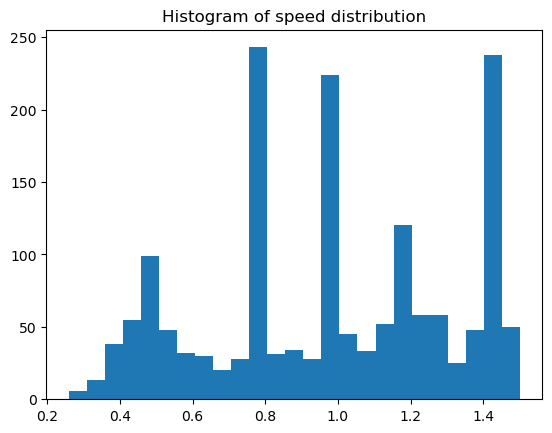

In [27]:
plt.hist(texts_imputed['target_speed'], bins=25)
plt.title("Histogram of speed distribution")

In [88]:
x = texts_imputed.iloc[:, 0:84]
y = texts_imputed.iloc[:, 84]
"""
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.001, random_state=42)



model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),  
    Dense(64, activation='relu'),  
    Dense(1, activation='softmax')  
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
"""

"\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(x)\n\n# Split the data into train and test sets\nx_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.001, random_state=42)\n\n\n\nmodel = Sequential([\n    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),  \n    Dense(64, activation='relu'),  \n    Dense(1, activation='softmax')  \n])\n\n# Compile model\nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\n"

In [89]:
# history = model.fit(x_train, y_train, epochs=40, validation_split=0.2)


In [92]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x, y)


RandomForestRegressor(random_state=42)

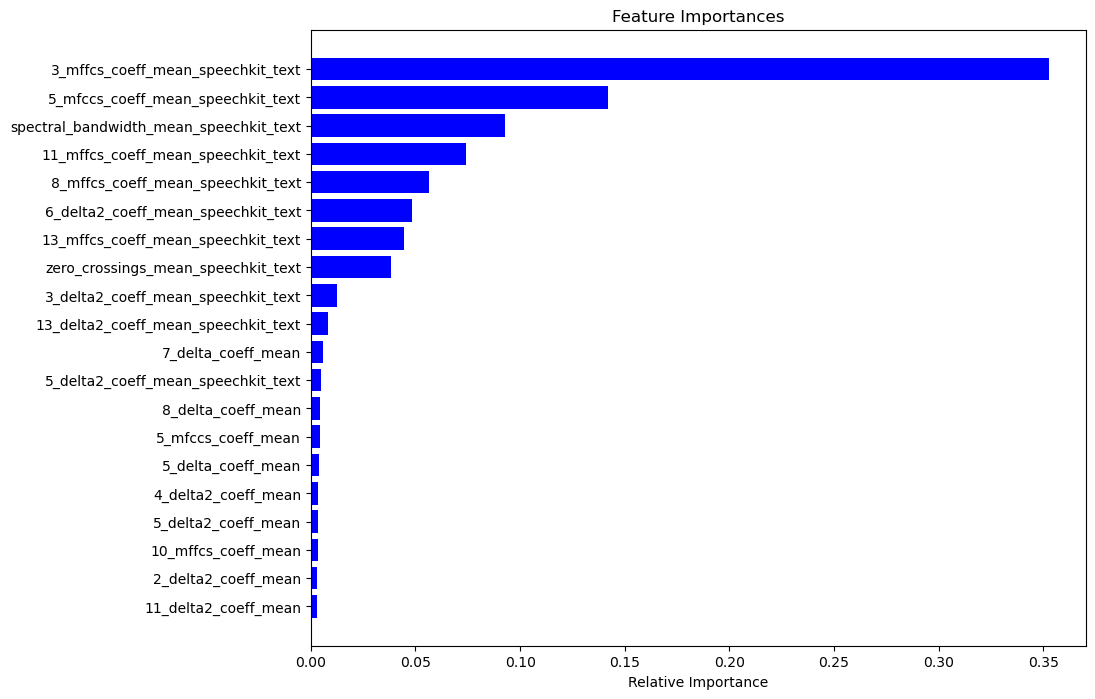

Mean Squared Error: 0.00892764252688171
R^2 Score: 0.6611771768926142


In [100]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


test = pd.read_csv('test.csv')
testx = test.iloc[:, 0:84]
testy = test.iloc[:, 84]

feature_importances = rf_regressor.feature_importances_
feature_names = testx.columns
indices = np.argsort(feature_importances)[::-1]

# Get the names of the top features
top_indices = indices[:20]  # Assuming you want top 20 features
top_feature_names = feature_names[top_indices]
top_importances = feature_importances[top_indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(top_importances)), top_importances[::-1], color='b', align='center')
plt.yticks(range(len(top_importances)), top_feature_names[::-1])
plt.xlabel('Relative Importance')
plt.show()

# Predictions
y_pred = rf_regressor.predict(testx)

# Calculate metrics
mse = mean_squared_error(testy, y_pred)
r2 = r2_score(testy, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


# feature_names = [f'Feature {i+1}' for i in range(80)]
# feature_importances = rf_regressor.feature_importances_

# # Filter and Extract Feature Names with Importance > 0.10
# important_features = [feature_names[i] for i in range(len(feature_importances)) if feature_importances[i] > 0.10]

# # Printing important features
# print("Features with Importance > 0.10:")
# for feature in important_features:
#     print(feature)

# plt.bar(range(len(feature_importances)), feature_importances)
# plt.title('Feature Importances')
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.show()


In [62]:
test_sample = pd.read_csv("testing_data.tsv", sep='\t')
test_sample = test_sample.drop(['GOLDEN:result_3d_question', 'GOLDEN:result_1st_question', 
             'GOLDEN:result_2nd_question', 'GOLDEN:result_4th_question', 
             'HINT:text', 'HINT:default_language', 
             'ASSIGNMENT:status',
             'ASSIGNMENT:started', 'ACCEPT:verdict', 'ACCEPT:comment',
             'ASSIGNMENT:link','ASSIGNMENT:task_id'], axis = 1)
# 'ASSIGNMENT:assignment_id'
test_sample.head(2)

INPUT:audio  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   

                                         INPUT:image  \
0  https://storage.yandexcloud.net/toloka-chebota...   
1  https://storage.yandexcloud.net/toloka-chebota...   

                          OUTPUT:recording OUTPUT:result_3d_question  \
0  eu.f9f537fb-4379-4061-9448-7c981c801aed                        No   
1  eu.77ea2bfb-42f9-4744-901c-9e49249e33fd                        No   

  OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
0                         No                        Yes   
1                        Yes                        Yes   

  OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
0                        Yes  00028f783b--6628f816da89fd4d182a7189   
1                        Yes  00028f783b--6628f82ca7929763eaab5118   

               ASSIGNMENT:worker_id  
0  e0681ec55630751f4d809c6a5a1f2c73  
1  49afc5bc9a5d286ffb0dbd0d197c52c0

In [63]:
import warnings
warnings.filterwarnings("ignore")
base_audio_path = "/Users/grigorijcebotarev/Desktop/untitled folder/testing"
audio_extensions = ['.wav', '.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp']

# Iterate over the rows in the dataframe
for index, row in test_sample.iterrows():
    # Assume no valid file is found initially
    valid_audio_file_path = None
    # Check each extension to find a valid audio file
    for ext in audio_extensions:
        potential_path = os.path.join(base_audio_path, f"assignment_{row['ASSIGNMENT:assignment_id']}"+"/"+row['OUTPUT:recording'] + ext)
        if os.path.isfile(potential_path):
            valid_audio_file_path = potential_path
            break
    
    # If a valid audio file is found, process it
    if valid_audio_file_path:
        # Extract audio features
        recording, sr = librosa.load(valid_audio_file_path)
        features_recording = extract_audio_features(recording, sr)
        speechkit_recording, _ = librosa.load(row['INPUT:audio'][50:])
        features_speechkit = extract_audio_features(speechkit_recording, sr, name = "_speechkit_text")
        features = pd.concat([features_recording, features_speechkit], axis = 1)
        test_sample.loc[index, features.columns] = features.iloc[0]
        # features_list.append(np.append(mfccs, zcr))
    else:
        # Optionally, append None or a placeholder if no valid audio file is found to maintain alignment
        # features_list.append("")
        # preferred_speeds.append("")  # Adjust as needed
        continue  # Skip the rest of the loop

Note: Illegal Audio-MPEG-Header 0x2c342c33 at offset 1337280.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Note: Illegal Audio-MPEG-Header 0x2c332c33 at offset 1871040.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Note: Illegal Audio-MPEG-Header 0x35372c34 at offset 1212480.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Note: Illegal Audio-MPEG-Header 0x31333434 at offset 1222080.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giv

In [68]:
test_sample[test_sample['1_mffcs_coeff_mean'].isna()]

INPUT:audio  \
184  https://storage.yandexcloud.net/toloka-chebota...   
202  https://storage.yandexcloud.net/toloka-chebota...   
352  https://storage.yandexcloud.net/toloka-chebota...   
356  https://storage.yandexcloud.net/toloka-chebota...   

                                           INPUT:image  \
184  https://storage.yandexcloud.net/toloka-chebota...   
202  https://storage.yandexcloud.net/toloka-chebota...   
352  https://storage.yandexcloud.net/toloka-chebota...   
356  https://storage.yandexcloud.net/toloka-chebota...   

                            OUTPUT:recording OUTPUT:result_3d_question  \
184  eu.2d927942-c9fb-4a1e-97c9-0619fab78b4e                        No   
202  eu.4734c65e-eeef-455c-a52f-97d7e6bc4bea                       Yes   
352  eu.496c2251-59f3-422f-9891-bf26ca84ea92                       Yes   
356  eu.4f3798a9-14fe-41f7-94c5-53188df5a87b                       Yes   

    OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
184                        Yes                        Yes   
202                         No                        Yes   
352                        Yes                        Yes   
356                        Yes                        Yes   

    OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
184                         No  00028f783b--6629049250de4e597ce5f4a5   
202                         No  00028f783b--66290681da89fd4d182b5f11   
352                         No  00028f783b--66292b88488b733e7c3b6408   
356                         No  00028f783b--66292cf4fe9e67602e8dafbd   

                 ASSIGNMENT:worker_id  1_mffcs_coeff_mean  ...  \
184  115bef105da3086e498e7c0faae46152                 NaN  ...   
202  115bef105da3086e498e7c0faae46152                 NaN  ...   
352  c0fc0469e16ae012f224617ff809e620                 NaN  ...   
356  c0fc0469e16ae012f224617ff809e620                 NaN  ...   

     4_delta2_coeff_mean_speechkit_text  5_delta2_coeff_mean_speechkit_text  \
184                                 NaN                                 NaN   
202                                 NaN                                 NaN   
352                                 NaN                                 NaN   
356                                 NaN                                 NaN   

     6_delta2_coeff_mean_speechkit_text  7_delta2_coeff_mean_speechkit_text  \
184                                 NaN                                 NaN   
202                                 NaN                                 NaN   
352                                 NaN                                 NaN   
356                                 NaN                                 NaN   

     8_delta2_coeff_mean_speechkit_text  9_delta2_coeff_mean_speechkit_text  \
184                                 NaN                                 NaN   
202                                 NaN                                 NaN   
352                                 NaN                                 NaN   
356                                 NaN                                 NaN   

     10_delta2_coeff_mean_speechkit_text  11_delta2_coeff_mean_speechkit_text  \
184                                  NaN                                  NaN   
202                                  NaN                                  NaN   
352                                  NaN                                  NaN   
356                                  NaN                                  NaN   

     12_delta2_coeff_mean_speechkit_text  13_delta2_coeff_mean_speechkit_text  
184                                  NaN                                  NaN  
202                                  NaN                                  NaN  
352                                  NaN                                  NaN  
356                                  NaN                                  NaN  

[4 rows x 93 columns]

In [71]:
test_sample.dropna(inplace = True)

In [74]:
for index, row in test_sample.iterrows():
    current_speed = float(row['INPUT:audio'][56:59])
    if (row['OUTPUT:result_1st_question'] == 'Yes' and 
        row['OUTPUT:result_2nd_question'] == 'Yes' and 
       (row['OUTPUT:result_3d_question'] == 'No' or row['OUTPUT:result_3d_question'] == 'None of the above') and 
        (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
        test_sample.loc[index, 'target_speed'] = current_speed
    elif(row['OUTPUT:result_1st_question'] == 'No' and 
            row['OUTPUT:result_2nd_question'] == 'Yes' and 
            (row['OUTPUT:result_3d_question'] == 'No'  or row['OUTPUT:result_3d_question'] == 'None of the above') and 
            (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
        test_sample.loc[index, 'target_speed'] = current_speed
    # elif(row['OUTPUT:result_1st_question'] == 'No' and 
    #         row['OUTPUT:result_2nd_question'] == 'No' and 
    #         row['OUTPUT:result_3d_question'] == 'Yes' and 
    #         row['OUTPUT:result_4th_question'] == 'No'):
    #     texts.loc[index, 'target_speed'] = current_speed - 0.25
    # elif(row['OUTPUT:result_1st_question'] == 'No' and 
    #         row['OUTPUT:result_2nd_question'] == 'No' and 
    #         row['OUTPUT:result_3d_question'] == 'No' and 
    #         row['OUTPUT:result_4th_question'] == 'Yes'):
    #     texts.loc[index, 'target_speed'] = current_speed + 0.25
    # else:
    #     texts.loc[index, 'target_speed'] = 1.0

In [77]:
test_sample.dropna(inplace = True)
test_sample

INPUT:audio  \
5    https://storage.yandexcloud.net/toloka-chebota...   
22   https://storage.yandexcloud.net/toloka-chebota...   
29   https://storage.yandexcloud.net/toloka-chebota...   
40   https://storage.yandexcloud.net/toloka-chebota...   
63   https://storage.yandexcloud.net/toloka-chebota...   
..                                                 ...   
563  https://storage.yandexcloud.net/toloka-chebota...   
566  https://storage.yandexcloud.net/toloka-chebota...   
567  https://storage.yandexcloud.net/toloka-chebota...   
572  https://storage.yandexcloud.net/toloka-chebota...   
573  https://storage.yandexcloud.net/toloka-chebota...   

                                           INPUT:image  \
5    https://storage.yandexcloud.net/toloka-chebota...   
22   https://storage.yandexcloud.net/toloka-chebota...   
29   https://storage.yandexcloud.net/toloka-chebota...   
40   https://storage.yandexcloud.net/toloka-chebota...   
63   https://storage.yandexcloud.net/toloka-chebota...   
..                                                 ...   
563  https://storage.yandexcloud.net/toloka-chebota...   
566  https://storage.yandexcloud.net/toloka-chebota...   
567  https://storage.yandexcloud.net/toloka-chebota...   
572  https://storage.yandexcloud.net/toloka-chebota...   
573  https://storage.yandexcloud.net/toloka-chebota...   

                            OUTPUT:recording OUTPUT:result_3d_question  \
5    eu.de367682-40d8-44c0-b6ff-bff6646e20c1                        No   
22   eu.4d33644a-fb3f-4f1f-bacb-2ea6c8f72d5c                        No   
29   eu.7c7cc93f-3be2-4ce5-ba0c-cf1f31cd5abd                        No   
40   eu.fdbbc403-55e6-4006-ad9a-be0d022aae10                        No   
63   eu.027163d0-6e99-4a44-bf88-79999336e2ff                        No   
..                                       ...                       ...   
563  eu.05f9804a-cd1c-4c8e-9a05-70bccadf8dfe                        No   
566  eu.2f848123-57f0-46dd-8ee8-55be2d772224                        No   
567  eu.6827e0ad-f6cf-4ed9-8f24-52c6728e29df                        No   
572  eu.5972fd31-965f-4341-b51f-157d48a61c3e                        No   
573  eu.a6541426-ca8e-4769-837c-e99d8c38ffd0                        No   

    OUTPUT:result_1st_question OUTPUT:result_2nd_question  \
5                           No                        Yes   
22                         Yes                        Yes   
29                          No                        Yes   
40                         Yes                        Yes   
63                         Yes                        Yes   
..                         ...                        ...   
563                         No                        Yes   
566                        Yes                        Yes   
567                        Yes                        Yes   
572                         No                        Yes   
573                        Yes                        Yes   

    OUTPUT:result_4th_question              ASSIGNMENT:assignment_id  \
5                           No  00028f783b--6628f85c03efe44efd8828f5   
22                          No  00028f783b--6628f91ea7929763eaab61c2   
29                          No  00028f783b--6628f998a7929763eaab6a59   
40                          No  00028f783b--6628fa48c56ff76833820277   
63                          No  00028f783b--6628fb5aa7929763eaab88b8   
..                         ...                                   ...   
563          None of the above  00028f783b--662b8517cb201c62ab5b79c0   
566                         No  00028f783b--662bb409cb201c62ab5f6268   
567                         No  00028f783b--662bb540f6eb632909e53146   
572                         No  00028f783b--662bc098f6eb632909e62a24   
573                         No  00028f783b--662bc3edf81b996bc6136232   

                 ASSIGNMENT:worker_id  1_mffcs_coeff_mean  ...  \
5    88068638195ce4efc7331d5bd197d567         -370.351288  ...   
22   9d6c0006b436c25a303f0e6e1

In [96]:
# test_sample = test_sample.drop(['INPUT:audio', 'INPUT:image', 'OUTPUT:recording', 
#                 'OUTPUT:result_3d_question', 'OUTPUT:result_1st_question', 
#                 'OUTPUT:result_2nd_question', 'OUTPUT:result_4th_question', 'ASSIGNMENT:assignment_id', 'ASSIGNMENT:worker_id'], axis = 1)
test_sample.to_csv('test.csv', index=False) 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.6390 - loss: 0.0000e+00


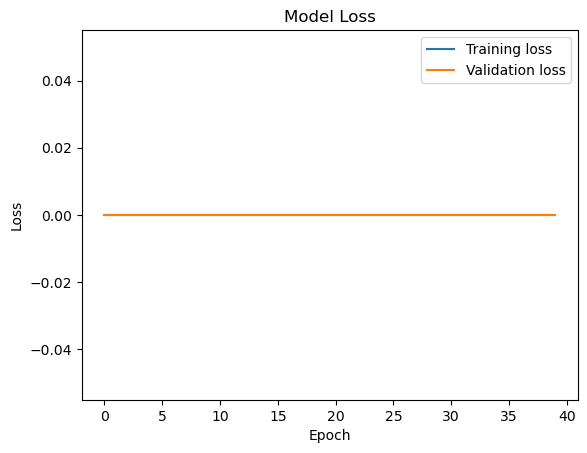

In [85]:
x_new = test_sample.iloc[:, 0:84]
y_new = test_sample.iloc[:, 84]
scaler = StandardScaler()
x_new_scaled = scaler.fit_transform(x_new)
test_loss, test_acc = model.evaluate(x_new_scaled, y_new)
# predictions = model.predict(x_new_scaled)
# predictions
test_acc

In [52]:
# for index, row in texts.iterrows():
#     current_speed = float(row['INPUT:audio'][56:59])
#     if (row['OUTPUT:result_1st_question'] == 'Yes' and 
#         row['OUTPUT:result_2nd_question'] == 'Yes' and 
#        (row['OUTPUT:result_3d_question'] == 'No' or row['OUTPUT:result_3d_question'] == 'None of the above') and 
#         (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
#         texts.loc[index, 'target_speed'] = current_speed
#     elif(row['OUTPUT:result_1st_question'] == 'No' and 
#             row['OUTPUT:result_2nd_question'] == 'Yes' and 
#             (row['OUTPUT:result_3d_question'] == 'No'  or row['OUTPUT:result_3d_question'] == 'None of the above') and 
#             (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
#         texts.loc[index, 'target_speed'] = current_speed
#     elif(row['OUTPUT:result_1st_question'] == 'No' and 
#             row['OUTPUT:result_2nd_question'] == 'No' and 
#             row['OUTPUT:result_3d_question'] == 'Yes' and 
#             row['OUTPUT:result_4th_question'] == 'No'):
#         texts.loc[index, 'target_speed'] = current_speed - 0.25
#     elif(row['OUTPUT:result_1st_question'] == 'No' and 
#             row['OUTPUT:result_2nd_question'] == 'No' and 
#             row['OUTPUT:result_3d_question'] == 'No' and 
#             row['OUTPUT:result_4th_question'] == 'Yes'):
#         texts.loc[index, 'target_speed'] = current_speed + 0.25
#     else:
#         texts.loc[index, 'target_speed'] = 1.0

In [80]:
X = texts.drop(['INPUT:audio', 'INPUT:image',
               'OUTPUT:recording', 'ASSIGNMENT:assignment_id','ASSIGNMENT:worker_id' ],axis=1)
X.rename(columns={"OUTPUT:result_1st_question": "one", 
                  "OUTPUT:result_2nd_question": "two",
                  "OUTPUT:result_3d_question": "three",
                  "OUTPUT:result_4th_question": "four"}, inplace = True)
X.one.replace(('Yes', 'No', 'None of the above'), (1, 0, 0), inplace=True)
X.two.replace(('Yes', 'No', 'None of the above'), (1, 0, 0), inplace=True)
X.three.replace(('Yes', 'No', 'None of the above'), (1, 0, 0), inplace=True)
X.four.replace(('Yes', 'No', 'None of the above'), (1, 0, 0), inplace=True)
y = texts['target_speed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [82]:
y_pred = lin_reg.predict(X_test)
y_pred

array([1.  , 0.75, 1.  , 1.  , 1.2 , 1.  , 1.  , 1.  , 1.  , 0.5 , 1.  ,
       1.  , 1.  , 1.  , 0.8 , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.8 , 0.8 , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.2 , 0.8 , 0.8 , 1.  , 1.  , 1.  , 1.  ,
       0.8 , 1.  , 1.  , 1.  , 0.8 , 1.  , 0.8 , 1.  , 1.  , 1.25, 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.25, 1.2 , 1.25, 1.25, 1.  ,
       1.  , 1.2 , 1.2 , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.2 , 0.8 , 1.  , 0.5 , 1.  , 1.2 , 1.  , 1.  , 1.2 , 1.  , 0.8 ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.5 , 1.  , 1.25, 1.  ,
       1.  , 1.  , 1.  , 0.8 , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.25, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       0.8 , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.

In [83]:
print('Linear Regression MSE:', mean_squared_error(y_test, y_pred))

Linear Regression MSE: 1.0480116438875142e-27


663

In [98]:
label_set1 = (texts["OUTPUT:result_1st_question"]== "Yes") & (texts["OUTPUT:result_2nd_question"] == "Yes") & \
((texts["OUTPUT:result_3d_question"] == "No") | (texts["OUTPUT:result_3d_question"] == "None of the above")) & \
((texts["OUTPUT:result_4th_question"] == "No") | (texts["OUTPUT:result_4th_question"] == "None of the above")) 

label_set2 = (texts["OUTPUT:result_1st_question"]== "No") & (texts["OUTPUT:result_2nd_question"] == "Yes") & \
(texts["OUTPUT:result_3d_question"] == "No")  & (texts["OUTPUT:result_4th_question"] == "No")

label_set3 = (texts["OUTPUT:result_1st_question"]== "None of the above") & (texts["OUTPUT:result_2nd_question"] == "Yes") & \
(texts["OUTPUT:result_3d_question"] == "No")  & (texts["OUTPUT:result_4th_question"] == "No")

label_set4 = (texts["OUTPUT:result_1st_question"]== "No") & (texts["OUTPUT:result_2nd_question"] == "Yes") & \
(texts["OUTPUT:result_3d_question"] == "None of the above")  & (texts["OUTPUT:result_4th_question"] == "None of the above")

labels = label_set1 + label_set2 + label_set3 + label_set4

In [99]:
print("Total comfortable speeches:", sum(labels>0))
print("Total uncomfortable speeches:", sum(labels==0))

Total comfortable speeches: 509
Total uncomfortable speeches: 1147


Processing texts assigned to speak

In [100]:
text_assigned = []
for link in texts["INPUT:image"]:
    # Split the link by '/' and extract the last part
    parts = link.split("/")
    filename = parts[-1]
    
    number = filename.split(".")[0]
    text_assigned.append(number)
   

Processing the speed assigned to speaker

In [101]:
types =[]
speed = []
for link in texts["INPUT:audio"]:
    # Split the link by '/' and extract the last part
    parts = link.split("/")
    filename = parts[-1]
    
    number = filename[:-4].split("_")
    types.append(number[0])
    speed.append(float(number[-1]))
    

Text(0.5, 1.0, 'Histogram of speed distribution')

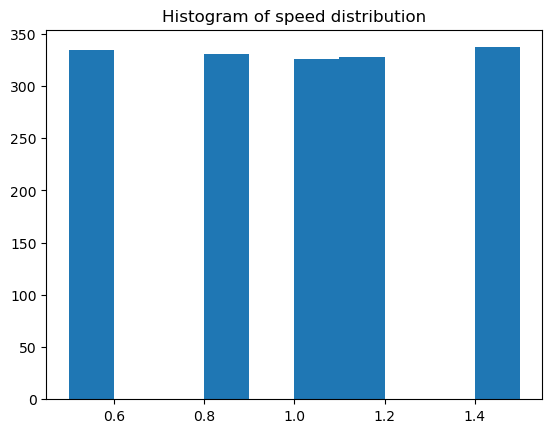

In [102]:
plt.hist(speed, bins=10)
plt.title("Histogram of speed distribution")

In [103]:
processed_data = pd.DataFrame({"Y": labels,"text_assigned":text_assigned, "listen_type":types, "speed":speed})
processed_data

Y text_assigned listen_type  speed
1     False             3       TextA    1.2
3     False             3       TextA    0.8
6     False             3       TextA    0.8
9      True             3       TextA    1.2
11     True             3       TextA    0.8
...     ...           ...         ...    ...
1979  False             9       TextC    1.2
1980  False             7       TextC    0.5
1981  False             9       TextC    1.2
1982  False            10       TextC    1.2
1983  False             7       TextC    0.5

[1656 rows x 4 columns]

# 